# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

## Цели и задачи исследования

**Цель исследования - проверить три гипотезы:**

    1. Цена объекта недвижимости зависит от параметров жилья.
    2. Цена объекта недвижимости зависит от его локации.
    2. Цена предложения в объявлении зависит от времени его размещения.

Для этого проанализируем имеющиеся данные из архива бъявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет.
    
Работу выполним в несколько этапов:
    
1. проверим данные на ошибки и устраним их - обработаем пропуски, дубликаты, выбивающиеся значения;
2. добавим в таблицу дополнительные расчетные параметры;
3. проанализируем статистику о характеристиках объектов;
4. изучим данные об объявлениях: датах их размещения и сроках экспозиции;
5. изучим связь цен с характеристиками объектов и объявлений.

### Изучение общей информации в файлах с данными. 

Подключим необходимые для работы библиотеки, считаем данные, изучим общую информацию о них.

In [1]:
import pandas as pd

In [2]:
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('real_estate_data.csv', sep='\t')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Файл хранит данные о 23699 объявлениях. Для каждого объекта недвижимости хранится до 22 характеристик.\
Переименуем столбец `cityCenters_nearest` для приведения к единообразному стилю.\
Выведем часть таблицы для ознакомления.

In [4]:
data = data.rename(columns={'cityCenters_nearest': 'city_centers_nearest'})
data.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1          11.0      2.0   посёлок Шушары           12817.0   
2           8.3      0.0  Санкт-Петербург           21741.0   
3           NaN      0.0  Санкт-Петербург           28098.0   
4          41.0      NaN  Санкт-Петербург           31856.0   

  city_centers_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0              16028.0               1.0          482.0               2.0   
1              18603.0               0.0            NaN               0.0   
2              13933.0               1.0           90.0               2.0   
3               6800.0               2.0           84.0               3.0   
4               8098.0               2.0          112.0               1.0   

   ponds_nearest  days_exposition  
0          755.0              NaN  
1            NaN             81.0  
2          574.0            558.0  
3          234.0            424.0  
4           48.0            121.0  

[5 rows x 22 columns]

Построим общую гистограмму для всех столбцов таблицы

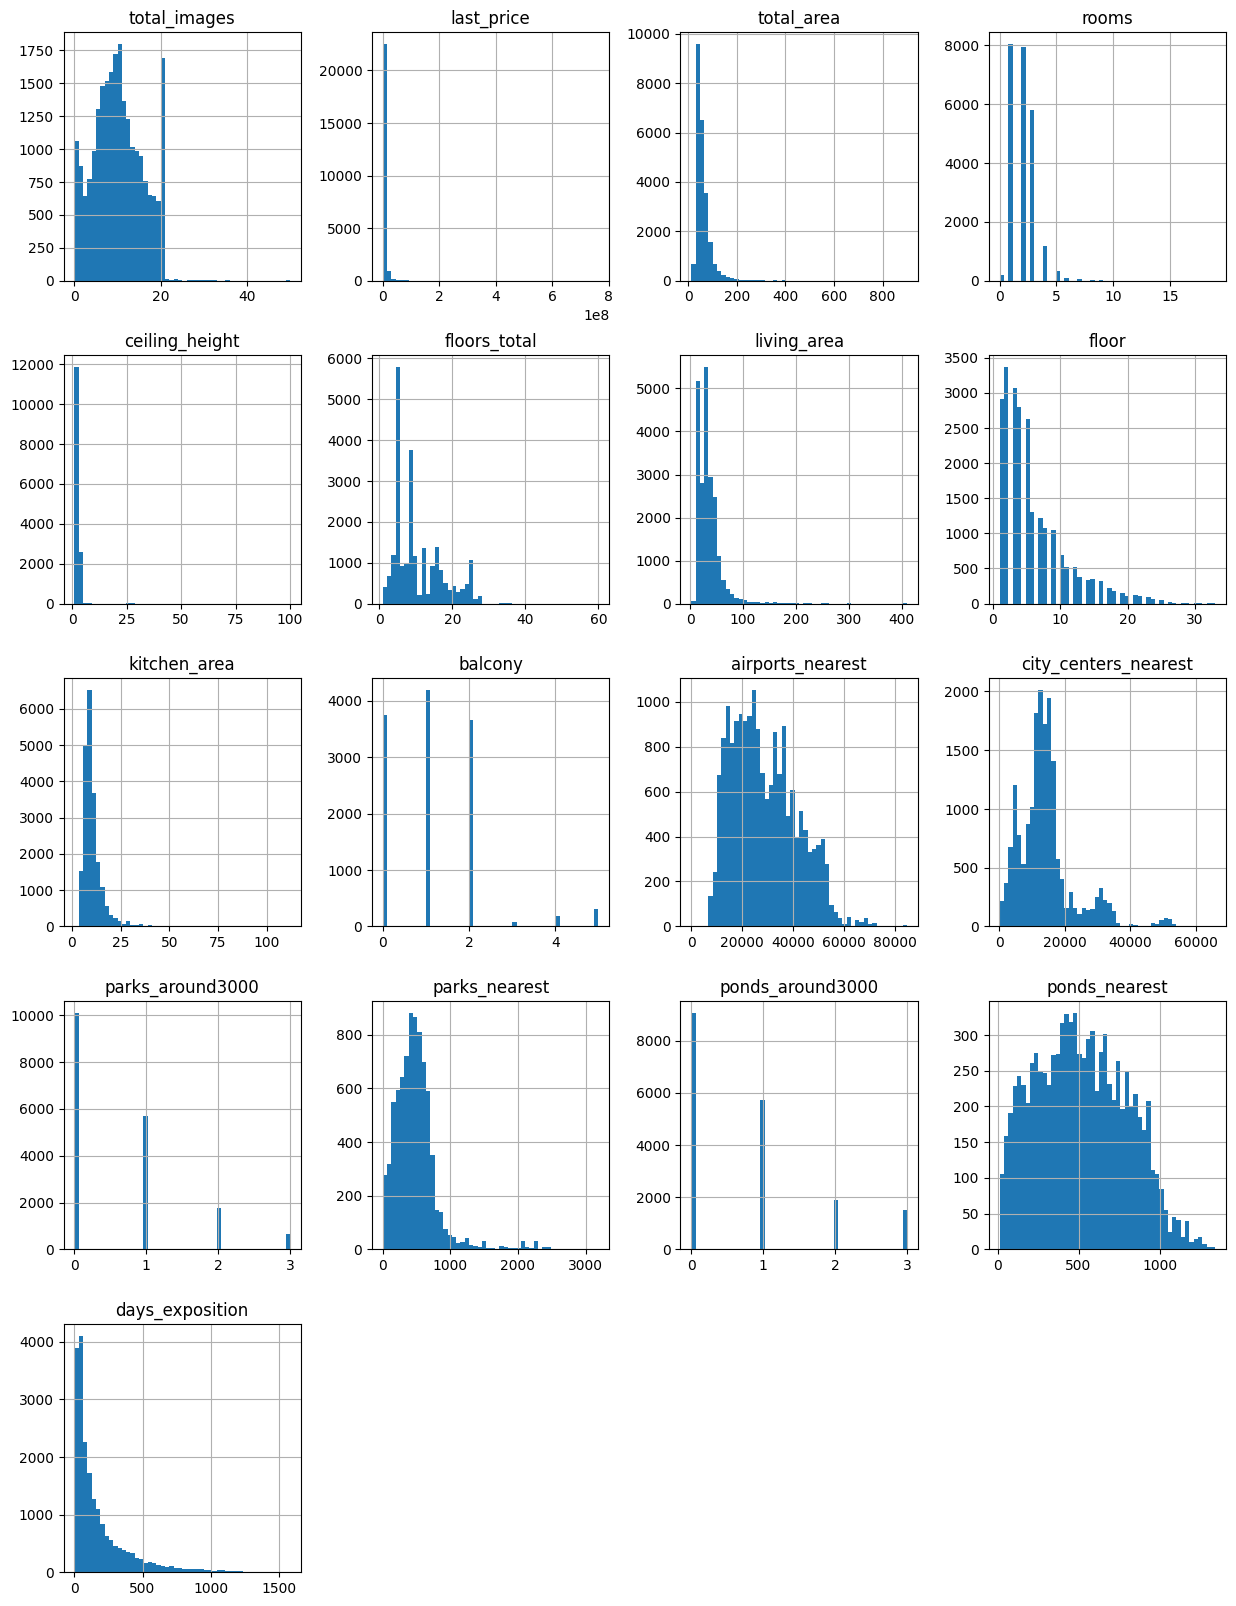

In [5]:
data.hist(bins=50, figsize=(15, 20));

### Предобработка данных

#### Проврка на наличие дубликатов

In [6]:
data.duplicated().sum()

0

Полных явных дуликатов в данных не выявлено.

#### Обработка пропусков

Определим, в каких столбцах есть пропуски, и их количество

In [7]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

Логично предположить, что, если продавец не указал количество болконов, то, скорее всего, в его квартире их нет. Заменим пропуски в столбце `balcony` на 0.

In [8]:
data['balcony'] = data['balcony'].fillna(0)

Аналогично заменим прпуски в данных о том, ялвяются ли продаваемые квартиры апартаментами, на значения `False`.

In [9]:
data['is_apartment'] = data['is_apartment'].fillna(False)

Вероятно, данные о высоте потолков, жилой площади и площади кухни у ряда объявлений отсутствуют по причине того, что продавец не знает точной информации об этом параметре жилья или не стал его указывать в объявлении. Заполним пропущенные данные медианными заначениями.

Но сначала проверим, как связаны разные характеристики жилья, - рассчитаем коэффициенты корреляции Пирсона.

In [10]:
data.loc[:, ['total_area', 
             'living_area', 
             'kitchen_area', 
             'ceiling_height', 
             'rooms', 
             'floor', 
             'floors_total']].corr()

total_area  living_area  kitchen_area  ceiling_height  \
total_area        1.000000     0.939537      0.609121        0.095490   
living_area       0.939537     1.000000      0.428674        0.090650   
kitchen_area      0.609121     0.428674      1.000000        0.087641   
ceiling_height    0.095490     0.090650      0.087641        1.000000   
rooms             0.758344     0.845977      0.269945        0.054457   
floor            -0.024754    -0.097210      0.135531       -0.011798   
floors_total     -0.075774    -0.169311      0.163944       -0.028732   

                   rooms     floor  floors_total  
total_area      0.758344 -0.024754     -0.075774  
living_area     0.845977 -0.097210     -0.169311  
kitchen_area    0.269945  0.135531      0.163944  
ceiling_height  0.054457 -0.011798     -0.028732  
rooms           1.000000 -0.150862     -0.228215  
floor          -0.150862  1.000000      0.678059  
floors_total   -0.228215  0.678059      1.000000

Максимальная корреляция наблюдается между жилой и общей площадью. Сильной корреляции между другими характеристиками не выявлено.

Так как высота потолков - величина относительно стабильная и не зависящая от других параметров жилья, то пропущенные данные о высоте потолков заполним медианными значениями относительно района.

In [11]:
ceiling_height_median = data['ceiling_height'].median()
data['ceiling_height'] = data['ceiling_height'].fillna(ceiling_height_median)

for locality in data['locality_name'].unique():
    median_ceil = data.loc[data['locality_name'] == locality, 'ceiling_height'].median()
    data.loc[(data['ceiling_height'].isna()) & (data['locality_name'] == locality), 'ceiling_height'] = median_ceil

Жилая площадь имеет сильную корреляцию с общей. Убедимся в этом, построив диаграмму рассеяния.

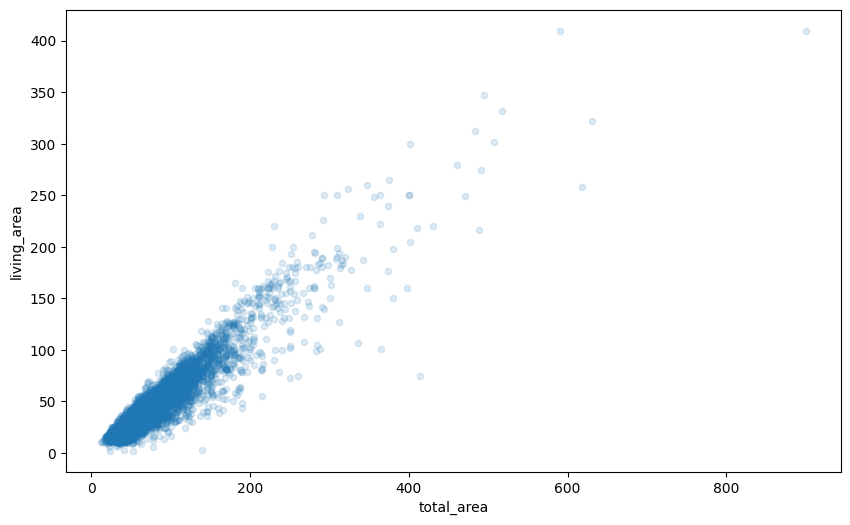

In [12]:
data.plot(kind='scatter', 
          x='total_area', 
          y='living_area', 
          alpha=0.15, 
          figsize=(10, 6));

Поэтому жилую площадь заполним медианными значениями в зависимости от общей площади. Для этого введем категориальную переменную на основе общей площади оъектов - разделим квартиры на группы:

    XXS - до 20 кв.м, 
    XS - от 20 до 30 кв.м,
    S - от 30 до 45 кв.м,
    M - от 45 до 60 кв.м,
    L - от 60 до 80 кв.м,
    XL - от 80 до 100 кв.м,
    XXL - от 100 до 150 кв.м,
    XXXL - более 150 кв.м.

In [13]:
def area_category(area):
    if area < 20:
        return 'XXS'
    if area < 30:
        return 'XS'
    if area < 45:
        return 'S'
    if area < 60:
        return 'M'
    if area < 80:
        return 'L'
    if area < 100:
        return 'XL'
    if area < 150:
        return 'XXL'
    return 'XXXL'

In [14]:
data['total_area_category'] = data['total_area'].apply(area_category)

На основе образованных категорий заполним пропущенные значения жилых площадей.

In [15]:
for cat in data['total_area_category'].unique():
    data.loc[(data['total_area_category'] == cat) & (data['living_area'].isna()), 'living_area'] = \
    data.loc[(data['total_area_category'] == cat), 'living_area'].median()

Аналогичной сильной зависимости между площадью кухни и общей/жилой площадью квартиры, к сожалению, не прослеживается. Пэтому пропущенные значения площадей кухни оставим незаполненными.

Проверим результат заполнения данных на правдоподобность - убедимся, что заполненные значения жилых площадей не оказались больше общих площадей изучаемых объектов.

In [16]:
data.query('total_area < living_area')

Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, city_centers_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition, total_area_category]
Index: []

[0 rows x 23 columns]

Некорректно заполненных значений нет. Можно пдвигаться дальше.

Скорее всего, данные о названии населенного пункта пропущены продавцом при подаче объявления. Введем заполнитель - `Неизвестно`.

In [17]:
data['locality_name'] = data['locality_name'].fillna('Неизвестно')

In [18]:
data.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area             2278
balcony                     0
locality_name               0
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
total_area_category         0
dtype: int64

**Выводы по этапу обработки пропусков**

В ходе обработки пропусков были заполнены отсутствующие данные о количестве балконов, жилых площадях и высоте потолков в рассматриваемых объявлениях, а также о том, является ли объект апартаментами. Пропуски в поле с названием населенного пункта заполнены формальным значением.

Пропуски в столбце с этажностью зания проблематично заменить на основе имеющихся данных, поэтому оставим их незаполненными.

Пропуски в данных о продолжительности размещения объявления могут говорить о том, что объявление так и не было снято с публикации. Оставим эти пропуски как есть.

Количество пропусков в геоданных (расстояния до центра города, аэропорта, парков и т.д.) говорят о проблеме в процессе сбора или обработки исходных данных. О ней стоит сообщить разработчикам.

#### Изменение типов данных в столбцах

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23699 non-null  object 
 15  airports_nearest   

Изменим данные в столбцах `last_price` и `balcony` на `integer`, так как целочисленные данные занимают меньше места в памяти, а высокой точности в данных столбцах нам для анализа не нужно. Столбец `first_day_exposition` заменим на `datetime` для получения доступа к методам этого типа данных.

In [20]:
data['last_price'] = round(data['last_price']).astype('int')
data['balcony'] = data['balcony'].astype('int')
data['first_day_exposition'] = \
pd.to_datetime(data['first_day_exposition'], format='%Y.%m.%dT%H:%M:%S')

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  int32         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

#### Обработка неявных дубликатов

Обработаем дубликаты в столбце с названиями населенных пунктов.

In [22]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [23]:
display(len(data['locality_name'].unique()))

365

Удалим из названий локаций наименования типов населенных пунктов, оставив только топографические наименования.

In [24]:
for word in ['поселок ',
             'посёлок ', 
             'городской ', 
             'деревня ', 
             'городского типа ', 
             'село ', 
             'садовое товарищество ',
             'коттеджный ',
             'станции ', 
             'садоводческое некоммерческое товарищество ', 
             'при железнодорожной ']:
    data['locality_name'] = data['locality_name'].str.replace(word, '')

Убедимся, что неявные дубликаты в столбце отсутствуют.

In [25]:
pd.set_option('display.max_rows', None)

display(data.groupby('locality_name')['locality_name'].count())

pd.reset_option('display.max_rows')

locality_name
Агалатово                      4
Александровская                2
Алексеевка                     1
Аннино                        16
Аро                            3
Барышево                       2
Батово                         9
Бегуницы                      17
Белогорка                     11
Белоостров                     1
Бокситогорск                  16
Большая Вруда                  4
Большая Ижора                 17
Большая Пустомержа             1
Большие Колпаны               16
Большое Рейзино                1
Большой Сабск                  1
Бор                            2
Борисова Грива                 1
Бугры                        114
Будогощь                       4
Ваганово                       3
Важины                         6
Вартемяги                     20
Вахнова Кара                   1
Вещево                         5
Виллози                        3
Вознесенье                     2
Возрождение                    3
Войсковицы                   

In [26]:
display(len(data['locality_name'].unique()))

306

**Вывод по этапу обработки дубликатов**

Осталось 306 уникальных названий населенных пунктов из первоначальных 365. Удалось избавится от 59 дублей.

#### Обработка выбивающихся значений

##### Высота потолков

In [27]:
data['ceiling_height'].describe()

count    23699.000000
mean         2.724358
std          0.988298
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

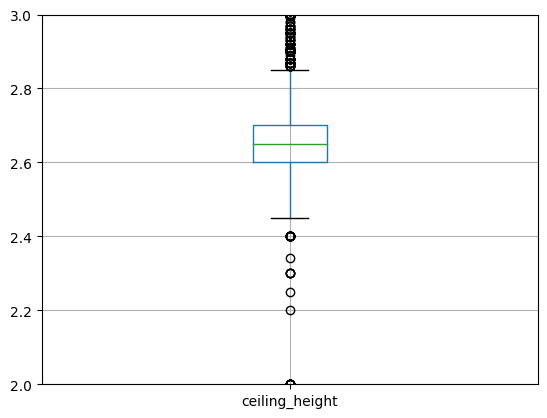

In [28]:
import matplotlib.pyplot as plt
data.boxplot('ceiling_height')
plt.ylim(2,3)
plt.show()

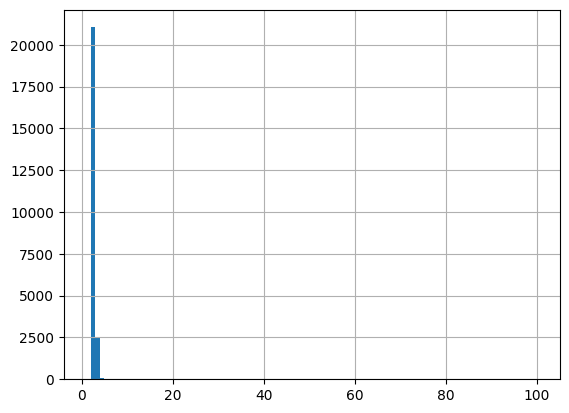

In [29]:
data['ceiling_height'].hist(bins=100);

Выбросы с нереалистично высокими потолками искажают данные.\
Посмотрим на объявления с ними поближе.

In [30]:
data[data['ceiling_height'] > 10]

total_images  last_price  total_area first_day_exposition  rooms  \
355              17     3600000        55.2           2018-07-12      2   
3148             14     2900000        75.0           2018-11-12      3   
4643              0     4300000        45.0           2018-02-01      2   
4876              7     3000000        25.0           2017-09-27      0   
5076              0     3850000        30.5           2018-10-03      1   
5246              0     2500000        54.0           2017-10-13      2   
5669              4     4400000        50.0           2017-08-08      2   
5807             17     8150000        80.0           2019-01-09      2   
6246              6     3300000        44.4           2019-03-25      2   
9379              5     3950000        42.0           2017-03-26      3   
10773             8     3800000        58.0           2017-10-13      2   
11285             0     1950000        37.0           2019-03-20      1   
14382             9     1700000        35.0           2015-12-04      1   
15061            19     5600000        56.4           2018-05-11      2   
17496            15     6700000        92.9           2019-02-19      3   
17857             1     3900000        56.0           2017-12-22      3   
18545             6     3750000        43.0           2019-03-18      2   
20478            11     8000000        45.0           2017-07-18      1   
20507            12     5950000        60.0           2018-02-19      2   
21377            19     4900000        42.0           2017-04-18      1   
21824            20     2450000        44.0           2019-02-12      2   
22309            20     5300000        45.0           2017-09-30      1   
22336            19     9999000        92.4           2019-04-05      2   
22869             0    15000000        25.0           2018-07-25      1   
22938            14     4000000        98.0           2018-03-15      4   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
355              25.0           5.0         32.0      2         False  ...   
3148             32.0           3.0         53.0      2         False  ...   
4643             25.0           9.0         30.0      2         False  ...   
4876             27.0          25.0         17.0     17         False  ...   
5076             24.0           5.0         19.5      1          True  ...   
5246             27.0           5.0         30.0      3         False  ...   
5669             26.0           9.0         21.3      3         False  ...   
5807             27.0          36.0         41.0     13         False  ...   
6246             25.0           5.0         31.3      5         False  ...   
9379             25.0           5.0         30.0      2         False  ...   
10773            27.0          10.0         30.1      3         False  ...   
11285            25.0           5.0         17.0      4         False  ...   
14382            25.0           5.0         20.0      2         False  ...   
15061            14.0          14.0         32.4      5         False  ...   
17496            20.0          17.0         53.2     14         False  ...   
17857            27.0           5.0         33.0      4         False  ...   
18545            25.0           5.0         29.0      3         False  ...   
20478            27.0           4.0         22.0      2         False  ...   
20507            22.6          14.0         35.0     11         False  ...   
21377            27.5          24.0         37.7     19         False  ...   
21824            27.0           2.0         38.0      2         False  ...   
22309            10.3          16.0         15.5     15         False  ...   
22336            32.0           6.0         55.5      5         False  ...   
22869           100.0           5.0         14.0      5          True  ...   
22938            27.0           2.0         73.0      2          True  ...   

       balcony    locality_

Имеется несколько значений от 24 до 32 метров. Похоже, что, на самом деле, это значения от 2,4 до 3.2 метров соответственно. Заменим их.

Также можно предположить, что высота 22,6 - это, на самом, деле 2,6.

In [31]:
data['ceiling_height'] = (
    data['ceiling_height']
    .where((data['ceiling_height'] < 24) 
           | (data['ceiling_height'] > 32) 
           | (data['ceiling_height'].isna()),
           data['ceiling_height'] / 10))
data['ceiling_height'] = data['ceiling_height'].replace(22.6, 2.6)

In [32]:
data['ceiling_height'].describe()

count    23699.000000
mean         2.703292
std          0.688444
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

In [33]:
data[data['ceiling_height'] <= 2.2]

total_images  last_price  total_area first_day_exposition  rooms  \
552              11     2999000       33.50           2017-03-30      1   
2572              4     2400000       62.00           2018-12-27      3   
4212              1     2120000       35.43           2017-12-18      1   
5712              5     1500000       42.80           2017-08-14      2   
5850              9     1650000       35.50           2018-05-29      1   
11352             4     3300000       36.00           2017-06-18      1   
12755             2     1400000       22.50           2017-09-21      1   
16446             6    12300000       88.30           2019-03-12      3   
16884             0     1500000       33.00           2018-10-03      1   
16934             5     4100000       40.00           2017-10-17      1   
19098             7     2700000       56.00           2018-02-04      3   
19329             5     1700000       40.00           2018-07-15      2   
20520             9     3600000       38.00           2018-07-05      1   
22590            16     6000000       55.00           2018-10-31      2   
22960            17     2300000       53.60           2018-10-18      2   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
552              2.00          15.0         17.5      6         False  ...   
2572             2.00           5.0         40.0      4         False  ...   
4212             2.00          18.0         16.6      9         False  ...   
5712             1.20           2.0         27.5      1         False  ...   
5850             2.00           5.0         18.0      5         False  ...   
11352            2.00          17.0         15.2     12         False  ...   
12755            2.20           2.0         18.0      2         False  ...   
16446            2.00           5.0         63.9      2         False  ...   
16884            2.00           5.0         20.0      5         False  ...   
16934            1.75          37.0         17.4      5         False  ...   
19098            2.00           5.0         46.0      1         False  ...   
19329            2.00           9.0         18.0      8         False  ...   
20520            2.00          12.0         15.0      9         False  ...   
22590            1.00          12.0         32.4      7         False  ...   
22960            2.00           2.0         19.0      1         False  ...   

       balcony    locality_name  airports_nearest  city_centers_nearest  \
552          0  Санкт-Петербург           33972.0               11746.0   
2572         1             Луга               NaN                   NaN   
4212         2            Тосно               NaN                   NaN   
5712         0              Мга               NaN                   NaN   
5850         0             Луга               NaN                   NaN   
11352        0     Металлострой           25268.0               26980.0   
12755        1          Копорье               NaN                   NaN   
16446        0  Санкт-Петербург           38415.0                7675.0   
16884        0           Выборг               NaN                   NaN   
16934        0  Санкт-Петербург           18732.0               20444.0   
19098        0           Выборг               NaN                   NaN   
19329        0     Сосновый Бор               NaN                   NaN   
20520        1          Кудрово               NaN                   NaN   
22590        0  Санкт-Петербург           33053.0               14217.0   
22960        0       Всеволожск               NaN                   NaN   

      parks_around3000  parks_nearest  ponds_around3000  ponds_nearest  \
552                1.0          520.0               1.0          949.0   
2572               NaN            NaN               NaN            NaN   
4212               NaN            NaN               NaN            NaN   
5712               NaN            NaN               NaN     

In [34]:
data[data['ceiling_height'] >= 5.5]

total_images  last_price  total_area first_day_exposition  rooms  \
1388             20    59800000       399.0           2015-01-21      5   
3474              3     1400000        30.0           2018-03-16      1   
5863             20     5650000        45.0           2018-08-15      1   
7578             17    38000000       143.0           2017-11-02      3   
15061            19     5600000        56.4           2018-05-11      2   
15743            14     5600000        67.0           2016-11-11      3   
17442             0     5350000        54.0           2015-06-16      2   
17496            15     6700000        92.9           2019-02-19      3   
20264            17   119000000       187.6           2017-07-10      4   
21227             0     8200000        71.0           2017-07-21      0   
22309            20     5300000        45.0           2017-09-30      1   
22869             0    15000000        25.0           2018-07-25      1   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
1388              5.6           6.0        111.0      6         False  ...   
3474              8.0           5.0         15.3      2         False  ...   
5863              8.3          16.0         19.3     14         False  ...   
7578              5.5           5.0         83.0      5         False  ...   
15061            14.0          14.0         32.4      5         False  ...   
15743             8.0          16.0         41.0      1         False  ...   
17442             8.0           5.0         29.0      2         False  ...   
17496            20.0          17.0         53.2     14         False  ...   
20264             6.0           7.0        147.0      7         False  ...   
21227             5.8           5.0         68.0      5         False  ...   
22309            10.3          16.0         15.5     15         False  ...   
22869           100.0           5.0         14.0      5          True  ...   

       balcony    locality_name  airports_nearest  city_centers_nearest  \
1388         0  Санкт-Петербург           26204.0                6934.0   
3474         0            Нурма               NaN                   NaN   
5863         1  Санкт-Петербург           13069.0               10763.0   
7578         1  Санкт-Петербург           26333.0                6448.0   
15061        2  Санкт-Петербург           14814.0               13610.0   
15743        0  Санкт-Петербург           32691.0               11035.0   
17442        1     Красное Село           24638.0               28062.0   
17496        5  Санкт-Петербург           16295.0               15092.0   
20264        0  Санкт-Петербург           26902.0                5605.0   
21227        0  Санкт-Петербург           20170.0                1261.0   
22309        0  Санкт-Петербург           36353.0               11936.0   
22869        5  Санкт-Петербург           34963.0                8283.0   

      parks_around3000  parks_nearest  ponds_around3000  ponds_nearest  \
1388               2.0          149.0               2.0          577.0   
3474               NaN            NaN               NaN            NaN   
5863               0.0            NaN               1.0          613.0   
7578               3.0          479.0               0.0            NaN   
15061              0.0            NaN               0.0            NaN   
15743              1.0          723.0               0.0            NaN   
17442              0.0            NaN               0.0            NaN   
17496              1.0          967.0               0.0            NaN   
20264              3.0          484.0               1.0          305.0   
21227              2.0          295.0               3.0          366.0   
22309              2.0          440.0               2.0          450.0   
22869              1.0          223.0               3.0           30.0   

       days_exposition  total_area_category  
1388             719.0         

Даже, если среди объявлений есть предложения о продаже двухэтажных квартир или квартир с антресолью, вряд ли высота потолков в них превышает 5 метров. Также очень неправдоподобными кажутся значения менее 2,2 метра. Всего таких выбивающихся значений - 27 штук. Так как природа появления таких данных неизвестна, заменим их на медианные.

In [35]:
data['ceiling_height'] = (
    data['ceiling_height']
    .where((data['ceiling_height'] > 2.2) & (data['ceiling_height'] < 5.5),
          data['ceiling_height'].median()))

In [36]:
data['ceiling_height'].describe()

count    23699.000000
mean         2.696705
std          0.216984
min          2.250000
25%          2.600000
50%          2.650000
75%          2.700000
max          5.300000
Name: ceiling_height, dtype: float64

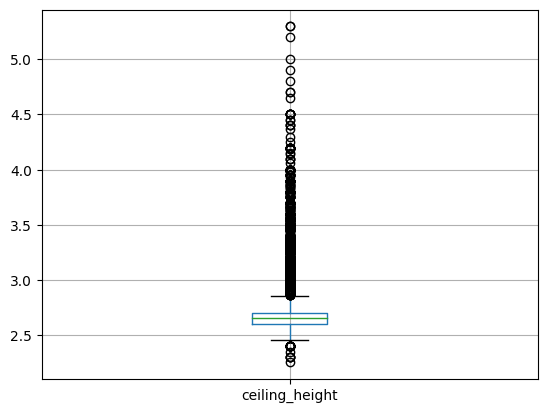

In [37]:
data.boxplot('ceiling_height');

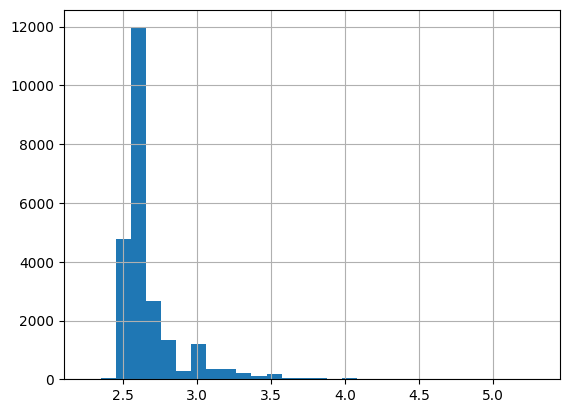

In [38]:
data['ceiling_height'].hist(bins=30);

Теперь распределение выглядит более реалистичным, а стандартное отклонение уменьшилось в несколько раз.

##### Общая площадь

In [39]:
data['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

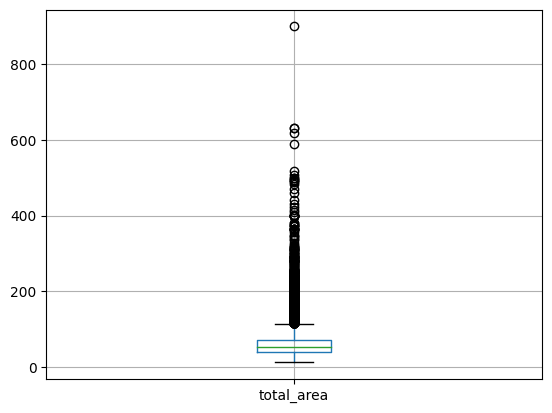

In [40]:
data.boxplot('total_area');

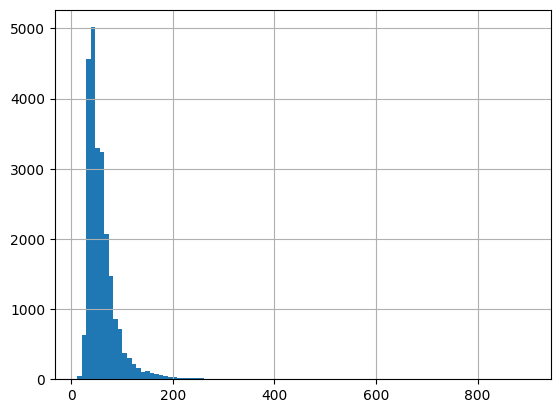

In [41]:
data['total_area'].hist(bins=100);

Имеются "выбросы" с большими значениями общей площади квартир. Но, помня о том, что Санкт-Петербург - город коммуналок, посмотрим на них ближе.

In [42]:
data[data['total_area'] >= 100]['total_area'].count()

1908

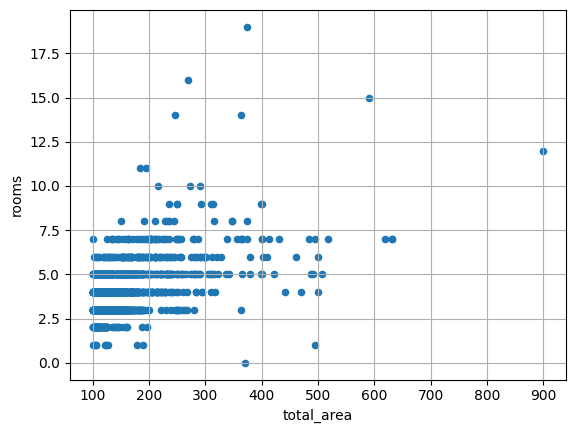

In [43]:
data[data['total_area'] >= 100].plot(
    x='total_area', 
    y='rooms', 
    kind='scatter', 
    grid=True);

Всего 1905 объявления с общей площадью от 100 кв.м. Причем, в основном, это квартиры, в которых три и более комнат, и в целом, видно, что с ростом метража увеличивается и количество комнат. Выглядит вполне правдоподобно.

In [44]:
data[data['total_area'] > 300]['total_area'].count()

61

In [45]:
data[data['total_area'] > 300]['total_area'].count()/len(data)

0.0025739482678594034

Количество самых больших квартир в выборке занимает очень небольшую долю, но они сильно влияют на статистические данные. Так, квартиры площадью более 300 кв.м составляют чуть более 0,25% выборки. Поэтом считаю целесообразным исключить такие объвления.

Также убедимся в отсутствии неправдоподобно маленьких квартир.

In [46]:
data.sort_values('total_area', ascending=True).head(10)

total_images  last_price  total_area first_day_exposition  rooms  \
19904             4     2400000        12.0           2017-07-19      1   
17961             3     1400000        13.0           2017-12-03      1   
19546             3     1850000        13.0           2019-03-11      1   
19807             0     3800000        13.0           2018-07-04      1   
19558             2     1686000        13.2           2018-12-17      1   
19642             5     1190000        14.0           2018-07-29      1   
16949             9     1550000        15.0           2018-08-21      1   
12040             5     1900000        15.0           2018-06-27      1   
8886             10     2450000        15.5           2018-08-22      0   
9412              5     2100000        16.0           2017-12-10      0   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
19904            2.55           5.0         10.0      2         False  ...   
17961            2.60           9.0         13.0      1         False  ...   
19546            3.40           5.0         13.0      2         False  ...   
19807            2.65           5.0         10.0      3         False  ...   
19558            2.65           5.0         13.0      1         False  ...   
19642            2.65           5.0         11.0      1         False  ...   
16949            2.70           9.0         13.0      1         False  ...   
12040            2.50           5.0         13.0      1         False  ...   
8886             2.65           5.0         10.0      2         False  ...   
9412             2.65           6.0         13.0      1         False  ...   

       balcony    locality_name  airports_nearest  city_centers_nearest  \
19904        0  Санкт-Петербург           21314.0                 964.0   
17961        0  Санкт-Петербург           14350.0               15945.0   
19546        0  Санкт-Петербург           24915.0                5483.0   
19807        0  Санкт-Петербург           21302.0                1242.0   
19558        0  Санкт-Петербург           19891.0                4165.0   
19642        0  Санкт-Петербург            9898.0               11122.0   
16949        0  Санкт-Петербург           51048.0               16376.0   
12040        0     Сосновый Бор               NaN                   NaN   
8886         0  Санкт-Петербург           24326.0                4589.0   
9412         0  Санкт-Петербург           20735.0                2111.0   

      parks_around3000  parks_nearest  ponds_around3000  ponds_nearest  \
19904              1.0          886.0               2.0           45.0   
17961              0.0            NaN               1.0          185.0   
19546              1.0          644.0               0.0            NaN   
19807              1.0          592.0               3.0           27.0   
19558              1.0          361.0               1.0          155.0   
19642              0.0            NaN               0.0            NaN   
16949              0.0            NaN               1.0         1079.0   
12040              NaN            NaN               NaN            NaN   
8886               0.0            NaN               1.0          446.0   
9412               2.0          228.0               3.0           72.0   

       days_exposition  total_area_category  
19904            200.0                  XXS  
17961            410.0                  XXS  
19546             24.0                  XXS  
19807              9.0                  XXS  
19558             19.0                  XXS  
19642              4.0                  XXS  
16949             42.0                  XXS  
12040             45.0                  XXS  
8886              27.0                  XXS  
9412               3.0                  XXS  

[10 rows x 23 columns]

Площадь жилья менее 16 кв.м не соответствует строительным нормам. Скрее всего, здесь закралась ошибка, или в этих объявлениях продаются не целые квартиры, а доли или отдельные комнаты. В этом случае оценка и анализ их цены должны проводиться отдельно от объявлений о продаже целых квартир. Считаю, что такие оъявления лучше так же исключить из анализа.

In [47]:
data = data.query('16 <= total_area <= 300')

In [48]:
data['total_area'].describe()

count    23629.000000
mean        59.468429
std         30.533740
min         16.000000
25%         40.000000
50%         52.000000
75%         69.500000
max        300.000000
Name: total_area, dtype: float64

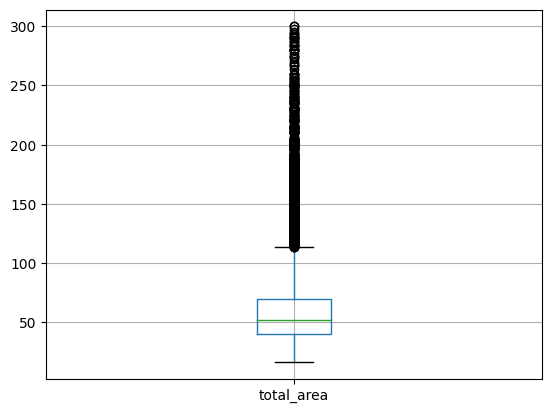

In [49]:
data.boxplot('total_area');

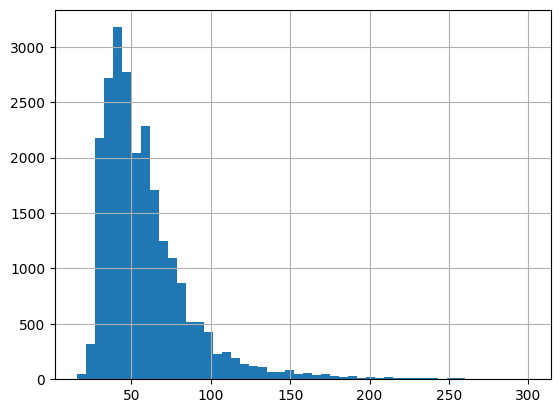

In [50]:
data['total_area'].hist(bins=50);

Теперь выбивающиеся значения не "подавлют" совей величиной общую картину. Можно продолжить дальнейший анализ.

##### Жилая площадь

Проверим, нет ли квартир с неправдоподобно маленькой жилой площадью.

In [51]:
data.sort_values('living_area', ascending=True).head(10)

total_images  last_price  total_area first_day_exposition  rooms  \
21758             0     2330000        23.0           2018-01-01      0   
13915            20     6350000        52.0           2018-02-06      2   
3242              7     4440000        41.0           2017-07-02      1   
23574            14    64990000       139.0           2015-11-24      3   
17582            11     2680000        22.0           2018-08-11      0   
21943            15     6100000        77.6           2019-02-28      4   
16431            13     3799000        31.0           2018-04-12      1   
19251            19     4050000        33.0           2018-10-15      1   
20994             7     8900000        50.6           2018-10-22      2   
23208            12     4800000        37.0           2016-02-24      1   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
21758            2.65          24.0          2.0     22         False  ...   
13915            3.00           6.0          2.0      2         False  ...   
3242             2.65          17.0          3.0     17         False  ...   
23574            3.00           8.0          3.0      8         False  ...   
17582            2.65          25.0          5.0      8         False  ...   
21943            2.50           9.0          5.4      1         False  ...   
16431            2.60           5.0          6.0      1         False  ...   
19251            2.50          22.0          6.5     21         False  ...   
20994            2.50           7.0          8.0      3         False  ...   
23208            2.65          14.0          8.0     11         False  ...   

       balcony    locality_name  airports_nearest  city_centers_nearest  \
21758        0           Мурино               NaN                   NaN   
13915        0  Санкт-Петербург           32453.0                6521.0   
3242         0  Санкт-Петербург           19272.0               13073.0   
23574        1  Санкт-Петербург           33255.0                5975.0   
17582        2  Санкт-Петербург           22735.0               11618.0   
21943        0  Санкт-Петербург           29338.0               11270.0   
16431        0  Санкт-Петербург           32177.0                4826.0   
19251        0  Санкт-Петербург            9258.0               10592.0   
20994        0  Санкт-Петербург           12771.0                8301.0   
23208        0  Санкт-Петербург           27838.0               12387.0   

      parks_around3000  parks_nearest  ponds_around3000  ponds_nearest  \
21758              NaN            NaN               NaN            NaN   
13915              0.0            NaN               1.0         1012.0   
3242               0.0            NaN               0.0            NaN   
23574              1.0          630.0               3.0          100.0   
17582              1.0          835.0               1.0          652.0   
21943              1.0          584.0               0.0            NaN   
16431              1.0          430.0               0.0            NaN   
19251              1.0          458.0               0.0            NaN   
20994              1.0          173.0               3.0          126.0   
23208              2.0          358.0               1.0          950.0   

       days_exposition  total_area_category  
21758             66.0                   XS  
13915             91.0                    M  
3242             216.0                    S  
23574            280.0                  XXL  
17582             70.0                   XS  
21943             33.0                    L  
16431            168.0                    S  
19251             44.0                    S  
20994              NaN                    M  
23208            139.0                    S  

[10 rows x 23 columns]

В таблице найдены объявления с жилой площадью вплоть до 2 кв.м. Причина появления таких данных не ясна, поэтому лучше их исключить. Оставим в данных только объявления с жилой площадью от 6 кв.м, удовлетворяющей требованиям санитарных норм. 

In [52]:
data = data.query('living_area >= 6')

##### Площадь кухонь

Проверим, сколько в таблице квартир с неправдоподобно маленькой и неправдоподобно большой площадью кухни.

In [53]:
data[data['kitchen_area'] < 5]['kitchen_area'].count()

104

In [54]:
data[data['kitchen_area'] > 50]['kitchen_area'].count()

36

Так как таких квартир мало, а реалистичность данных под вопросом, удалим их из таблицы.

In [55]:
data = data.query('5 <= kitchen_area <= 50')

##### Последняя цена

Изучим данные о ценах.

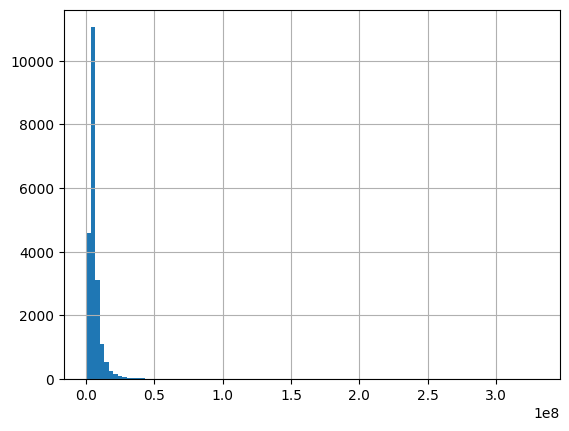

In [56]:
data['last_price'].hist(bins=100);

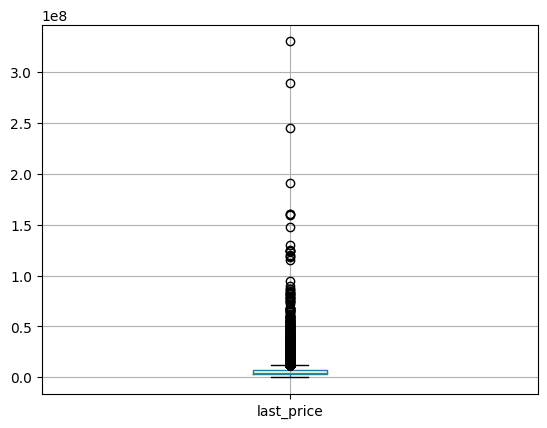

In [57]:
data.boxplot('last_price');

In [58]:
data['last_price'].describe()

count    2.122800e+04
mean     6.307343e+06
std      7.533782e+06
min      1.219000e+04
25%      3.500000e+06
50%      4.700000e+06
75%      6.800000e+06
max      3.300000e+08
Name: last_price, dtype: float64

Посмотрим на самые дорогие объекты.

In [59]:
data.sort_values(by='last_price', ascending=False).head(10)

total_images  last_price  total_area first_day_exposition  rooms  \
1436             19   330000000       190.0           2018-04-04      3   
22831            18   289238400       187.5           2019-03-19      2   
16461            17   245000000       285.7           2017-04-10      6   
8900             13   190870000       268.0           2016-03-25      3   
19155            20   160000000       243.0           2018-11-12      5   
2536             16   159984000       242.4           2015-08-27      4   
16495            12   159000000       260.0           2017-04-04      4   
22229            16   148000000       256.0           2016-03-16      5   
13864            20   130000000       231.0           2015-08-13      6   
1928             11   125000000       224.5           2017-01-24      4   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
1436             3.50           7.0         95.0      5         False  ...   
22831            3.37           6.0         63.7      6         False  ...   
16461            3.35           7.0        182.8      4         False  ...   
8900             2.65           8.0        132.0      7         False  ...   
19155            2.65           5.0        145.0      4         False  ...   
2536             3.85           9.0        131.0      7         False  ...   
16495            2.65           5.0        180.0      4         False  ...   
22229            2.65           6.0        179.0      5         False  ...   
13864            3.60           6.0        148.0      4         False  ...   
1928             2.65           4.0        163.5      3         False  ...   

       balcony    locality_name  airports_nearest  city_centers_nearest  \
1436         0  Санкт-Петербург           23011.0                1197.0   
22831        0  Санкт-Петербург           22494.0                1073.0   
16461        0  Санкт-Петербург           33143.0                6235.0   
8900         0  Санкт-Петербург           32440.0                5297.0   
19155        0  Санкт-Петербург           22640.0                 555.0   
2536         0  Санкт-Петербург           21946.0                2242.0   
16495        2  Санкт-Петербург           21740.0                 436.0   
22229        0  Санкт-Петербург           24072.0                3639.0   
13864        0  Санкт-Петербург           22992.0                1280.0   
1928         1  Санкт-Петербург           22805.0                2335.0   

      parks_around3000  parks_nearest  ponds_around3000  ponds_nearest  \
1436               3.0          519.0               3.0          285.0   
22831              3.0          386.0               3.0          188.0   
16461              3.0          400.0               3.0          140.0   
8900               0.0            NaN               2.0          198.0   
19155              3.0          285.0               1.0          200.0   
2536               1.0          679.0               1.0          227.0   
16495              2.0          138.0               3.0          620.0   
22229              2.0          727.0               3.0          462.0   
13864              3.0          395.0               3.0          170.0   
1928               0.0            NaN               2.0          497.0   

       days_exposition  total_area_category  
1436             233.0                 XXXL  
22831              NaN                 XXXL  
16461            249.0                 XXXL  
8900             901.0                 XXXL  
19155             18.0                 XXXL  
2536             501.0                 XXXL  
16495            178.0                 XXXL  
22229            233.0                 XXXL  
13864            467.0                 XXXL  
1928             174.0                 XXXL  

[10 rows x 23 columns]

Данные выглядят вполне реалистичными - похоже на элитное жилье.

Посмотрим, какую долю занимают самые дорогие объекты стоимостью более 50 милн.

In [60]:
data[data['last_price'] > 50_000_000]['last_price'].count()

77

In [61]:
data[data['last_price'] > 50_000_000]['last_price'].count() / len(data)

0.0036272847182965895

Менее 0,5%. Исключим их из рассматриваемых данных, так как такое жилье занимает незначительную долю в выборке, но сильно влияет на распределение значений цен, и будет в дальнейшем негативно влиять на результаты анализа.

In [62]:
data = data.query('last_price <= 50_000_000')

Теперь посмотрим на самые дешевые предложения.

In [63]:
data.sort_values(by='last_price', ascending=True).head(10)

total_images  last_price  total_area first_day_exposition  rooms  \
8793              7       12190       109.0           2019-03-20      2   
17456             7      430000        30.4           2019-04-22      1   
9581              7      450000        43.4           2018-08-31      2   
17676             0      450000        36.5           2018-02-01      1   
5698              7      450000        42.0           2017-07-31      2   
23484            11      470000        44.5           2018-07-02      2   
18867             1      470000        41.0           2018-02-11      1   
10782             3      490000        29.1           2016-05-05      1   
2097              9      500000        30.7           2019-04-30      1   
4405              9      500000        52.0           2018-08-02      2   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
8793             2.75          25.0         32.0     25         False  ...   
17456            2.65           2.0         16.0      1         False  ...   
9581             2.65           5.0         30.3      3         False  ...   
17676            2.65           5.0         17.3      4         False  ...   
5698             2.65           1.0         23.0      1         False  ...   
23484            2.65           2.0         28.0      2         False  ...   
18867            2.65           5.0         32.0      3         False  ...   
10782            2.50           5.0         17.0      5         False  ...   
2097             2.65           2.0         15.1      2         False  ...   
4405             2.70           2.0         31.0      1         False  ...   

       balcony    locality_name  airports_nearest  city_centers_nearest  \
8793         0  Санкт-Петербург           36421.0                9176.0   
17456        0           Сланцы               NaN                   NaN   
9581         0       Старополье               NaN                   NaN   
17676        1        Ям-Тесово               NaN                   NaN   
5698         0         Будогощь               NaN                   NaN   
23484        0           Сланцы               NaN                   NaN   
18867        0         Выскатка               NaN                   NaN   
10782        0           Сланцы               NaN                   NaN   
2097         0      Чудской Бор               NaN                   NaN   
4405         0           Сланцы               NaN                   NaN   

      parks_around3000  parks_nearest  ponds_around3000  ponds_nearest  \
8793               1.0          805.0               0.0            NaN   
17456              NaN            NaN               NaN            NaN   
9581               NaN            NaN               NaN            NaN   
17676              NaN            NaN               NaN            NaN   
5698               NaN            NaN               NaN            NaN   
23484              NaN            NaN               NaN            NaN   
18867              NaN            NaN               NaN            NaN   
10782              NaN            NaN               NaN            NaN   
2097               NaN            NaN               NaN            NaN   
4405               NaN            NaN               NaN            NaN   

       days_exposition  total_area_category  
8793               8.0                  XXL  
17456              NaN                    S  
9581              96.0                    S  
17676            120.0                    S  
5698             233.0                    S  
23484            298.0                    S  
18867             46.0                    S  
10782            719.0                   XS  
2097               NaN                    S  
4405             110.0                    M  

[10 rows x 23 columns]

Одно объявление имеет неадекватно низкую цену. Судя по остальным параметрам, автор забыл дописать три нуля. Исправим это недоразумение.

In [64]:
data['last_price'] = data['last_price'].replace(12190, 12190000)

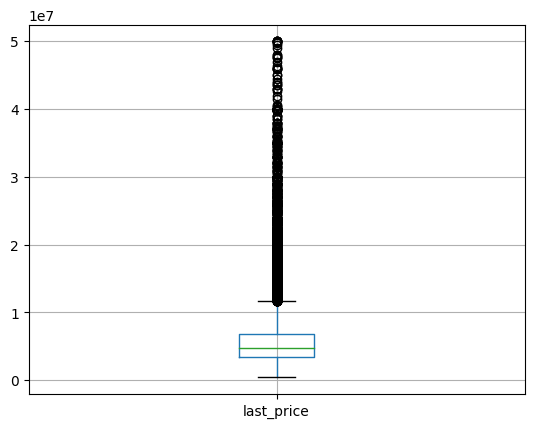

In [65]:
data.boxplot('last_price');

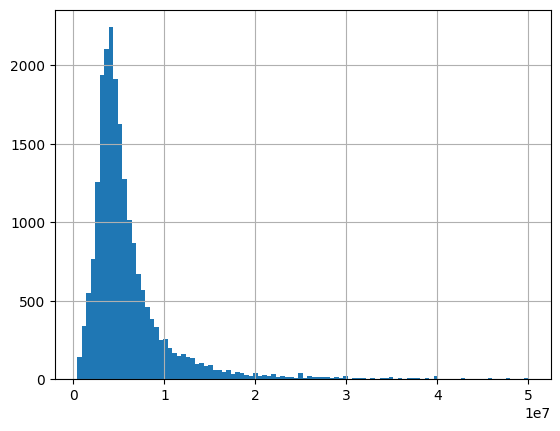

In [66]:
data['last_price'].hist(bins=100);

In [67]:
data['last_price'].describe()

count    2.115100e+04
mean     6.010615e+06
std      4.809769e+06
min      4.300000e+05
25%      3.500000e+06
50%      4.700000e+06
75%      6.760000e+06
max      5.000000e+07
Name: last_price, dtype: float64

Теперь график последней цены выглядиь более адекватным. Можно перейти к спледующему параметру объявлений.

##### Этажность зданий

Оценим адекватность информации об этажности зданий

In [68]:
data.sort_values(by='floors_total', ascending=False).head()

total_images  last_price  total_area first_day_exposition  rooms  \
2253             12     3800000        45.5           2018-06-28      2   
16731             9     3978000        40.0           2018-09-24      1   
16934             5     4100000        40.0           2017-10-17      1   
397              15     5990000        54.0           2018-03-22      2   
5807             17     8150000        80.0           2019-01-09      2   

       ceiling_height  floors_total  living_area  floor  is_apartment  ...  \
2253             2.88          60.0         27.4      4         False  ...   
16731            2.65          52.0         10.5     18         False  ...   
16934            2.65          37.0         17.4      5         False  ...   
397              2.65          36.0         21.4     28         False  ...   
5807             2.70          36.0         41.0     13         False  ...   

       balcony    locality_name  airports_nearest  city_centers_nearest  \
2253         0        Кронштадт           67763.0               49488.0   
16731        0  Санкт-Петербург           20728.0               12978.0   
16934        0  Санкт-Петербург           18732.0               20444.0   
397          1  Санкт-Петербург           18732.0               20444.0   
5807         5  Санкт-Петербург           18732.0               20444.0   

      parks_around3000  parks_nearest  ponds_around3000  ponds_nearest  \
2253               2.0          342.0               3.0          614.0   
16731              1.0          793.0               0.0            NaN   
16934              0.0            NaN               3.0           80.0   
397                0.0            NaN               3.0           80.0   
5807               0.0            NaN               3.0           80.0   

       days_exposition  total_area_category  
2253             166.0                    M  
16731             45.0                    S  
16934             71.0                    S  
397               11.0                    M  
5807              38.0                   XL  

[5 rows x 23 columns]

В объявлениях имются явные ошибки. Можно предположить, что 60 этажей - это, на самом деле, 6, так как максимальная этажность в Кронштадте - 15 этажей. Также выделяется значение 52. Предположительно, истинное значение - 25. Заменим указанные ошибки.

In [69]:
data['floors_total'] = data['floors_total'].replace({60.0: 6, 52.0: 25})

##### Расстояние до ближайшего аэропорта

Посмотрим на минимальные значения расстояний до аэропорта

In [70]:
data['airports_nearest'].sort_values().head(5)

21085       0.0
12899    6450.0
4017     6450.0
7778     6914.0
23150    6949.0
Name: airports_nearest, dtype: float64

Удалим неадекватное значение расстояния до аэропорта, равное 0 метров.

In [71]:
data = data.query('airports_nearest != 0')

##### Количество балконов

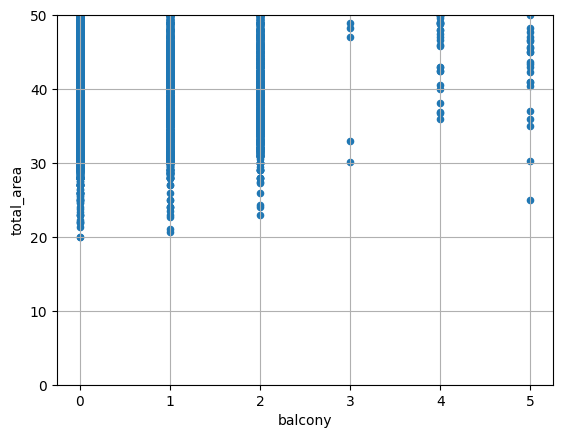

In [72]:
data.plot(x='balcony', y='total_area', kind='scatter', grid=True, ylim=(0, 50));

Квартиры площадью 25 - 50 кв.м с тремя, четырьмя и, даже, пятью баолконами... В данных явно имеется ошибка, но как ее исправить, пока не понятно. Оставим эти данные как есть, а об ошибке лучше сообщить разработчикам.

**Вывод по этапу устранения редких и выбивающихся значений**

*Устранены редкие и выбивающиеся значения высоты потолков, общей, жилой и площади кухни, последней цены, этажности зданий и расстояния до аэропорта. Там, где причины появления ошибок были понятными, произведена замена значений на более реалистичные. А объявления с невыясненной причиной появления ошибок были удалены.*

Также выявлена системная ошибка в поле "количество балконов", требующая дальнейшего исследования.

### Добавление столбцов для анализа

Добавим столбец с ценой за квадратный метр.

In [73]:
data['meter_price'] = data['last_price'] / data['total_area']

Добавим столбцы с днем недели, месяцем и годом публикации объявления.

In [74]:
data['day_of_week'] = data['first_day_exposition'].dt.dayofweek

In [75]:
data['first_month_exposition'] = data['first_day_exposition'].astype('datetime64[M]')

In [76]:
data['month'] = data['first_day_exposition'].dt.month

In [77]:
data['year'] = data['first_day_exposition'].dt.year

Добавим столбец со значением типа этажа квартиры:

    - первый,
    - последний,
    - другой

In [78]:
def floor_type(row):
    if row['floor'] == 1:
        return 'first'
    if row['floor'] == row['floors_total']:
        return 'last'
    return 'other'

In [79]:
data['floor_type'] = data.apply(floor_type, axis=1)

Добавим столбец с расстоянием до центра города в километрах.

In [80]:
data['city_centers_nearest_km'] = round(data['city_centers_nearest'] / 1000)

In [81]:
data = data.reset_index(drop=True)

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21150 entries, 0 to 21149
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_images             21150 non-null  int64         
 1   last_price               21150 non-null  int32         
 2   total_area               21150 non-null  float64       
 3   first_day_exposition     21150 non-null  datetime64[ns]
 4   rooms                    21150 non-null  int64         
 5   ceiling_height           21150 non-null  float64       
 6   floors_total             21112 non-null  float64       
 7   living_area              21150 non-null  float64       
 8   floor                    21150 non-null  int64         
 9   is_apartment             21150 non-null  bool          
 10  studio                   21150 non-null  bool          
 11  open_plan                21150 non-null  bool          
 12  kitchen_area             21150 n

После всех преобразований в таблице осталось 21150 записей. Таблица имеет 28 столбцов.

### Исследовательский анализ данных

#### Изучим параметры объектов

##### Изучим общие площади

In [83]:
data['total_area'].describe()

count    21150.000000
mean        59.361854
std         28.546797
min         20.000000
25%         40.600000
50%         52.200000
75%         69.700000
max        297.500000
Name: total_area, dtype: float64

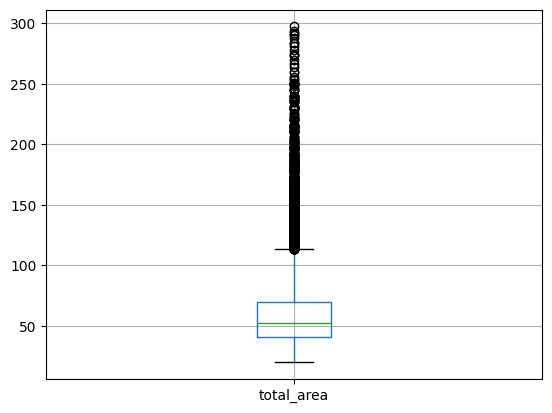

In [84]:
data.boxplot('total_area');

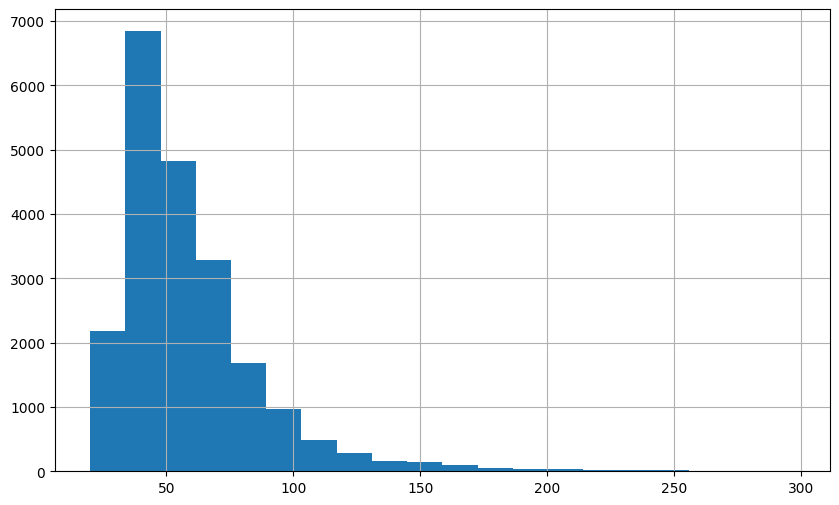

In [85]:
data['total_area'].hist(bins=20, figsize=(10, 6));

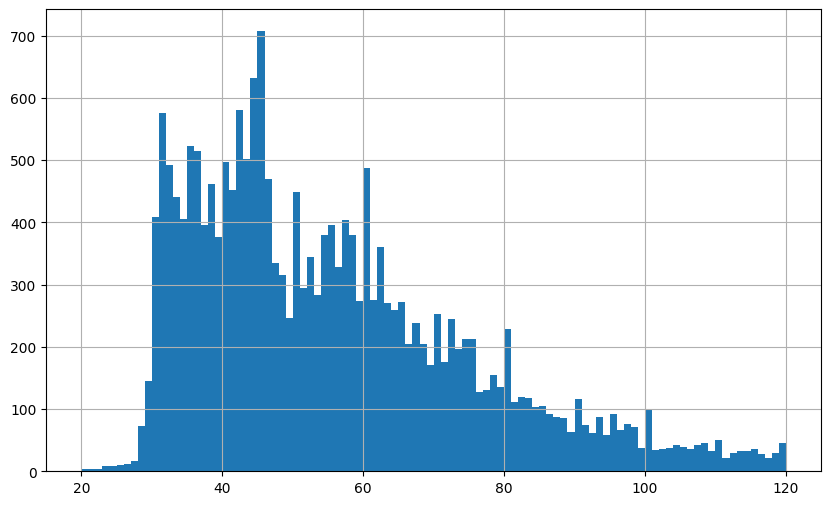

In [86]:
data['total_area'].hist(bins=100, figsize=(10, 6), range=(20, 120));

Медиана значений общих площадей продаваемых квартир равна 52,2 кв.м., среднее значение - 59,4 кв.м, первый квартиль - 40,6 кв.м, третий - 69,7.

При этом график имеет несколько всплесков - в районах 30, 45, 60 и 80 кв.м, что, скорее всего, обусловлено большим количеством проектов типовой застройки со стандартными площадями жилья.

##### Изучим жилые площади

In [87]:
data['living_area'].describe()

count    21150.000000
mean        33.988305
std         18.900931
min          6.000000
25%         18.700000
50%         30.000000
75%         42.200000
max        225.900000
Name: living_area, dtype: float64

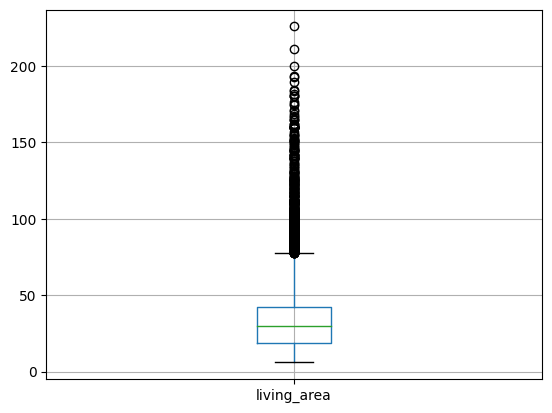

In [88]:
data.boxplot('living_area');

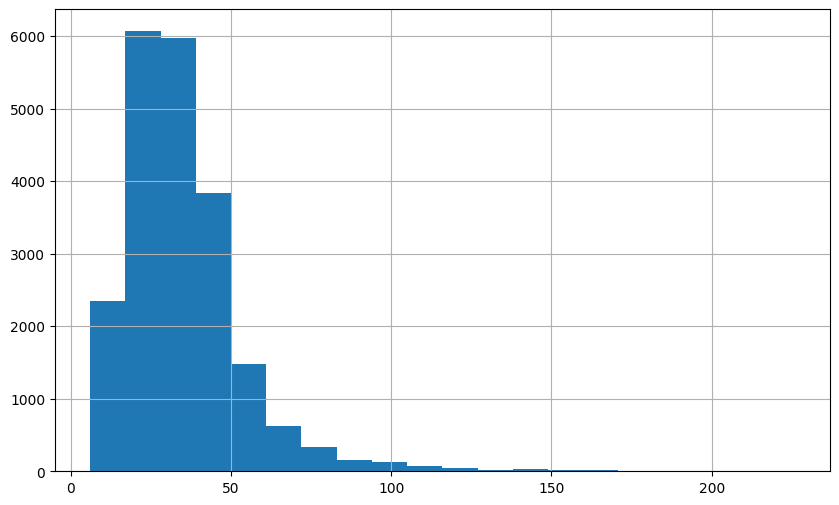

In [89]:
data['living_area'].hist(bins=20, figsize=(10, 6));

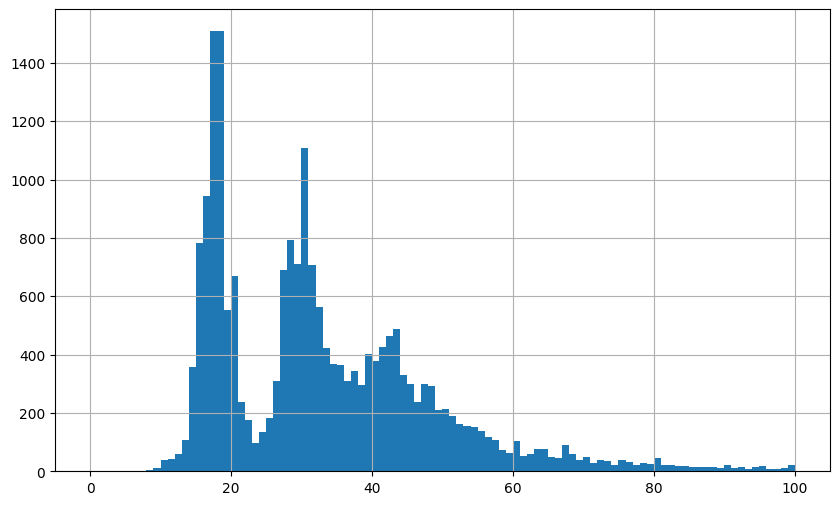

In [90]:
data['living_area'].hist(bins=100, figsize=(10, 6), range=(0, 100));

Медиана значений жилых площадей продаваемых квартир равна 30 кв.м., среднее значение - 34 кв.м, первый квартиль - 18,7 кв.м, третий - 42,2.

При этом на графике жилой площади в сравнении с графиком общей площади еще сильнее заметны всплески - в районах 18, 30 и 40 кв.м, что так же обусловлено большим количеством типовых проектов застройки со стандартными площадями жилья.

##### Изучим площади кухонь

In [91]:
data['kitchen_area'].describe()

count    21150.000000
mean        10.395506
std          5.084523
min          5.000000
25%          7.000000
50%          9.100000
75%         12.000000
max         50.000000
Name: kitchen_area, dtype: float64

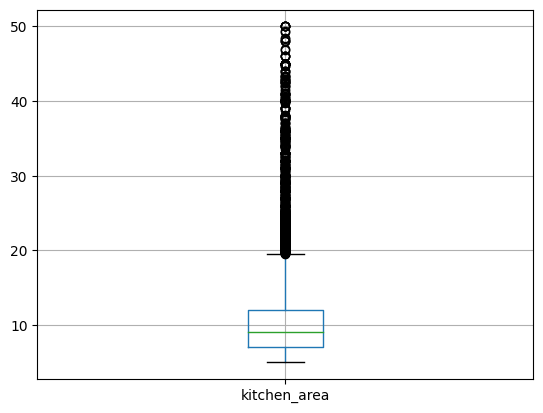

In [92]:
data.boxplot('kitchen_area');

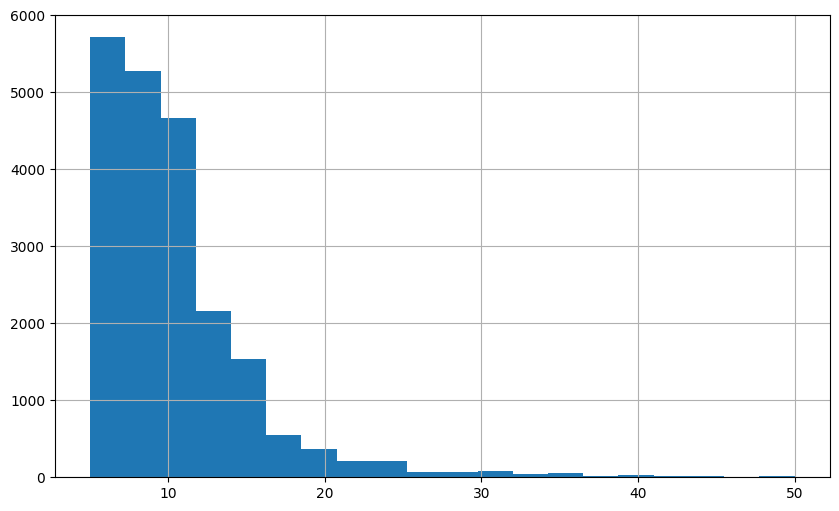

In [93]:
data['kitchen_area'].hist(bins=20, figsize=(10, 6));

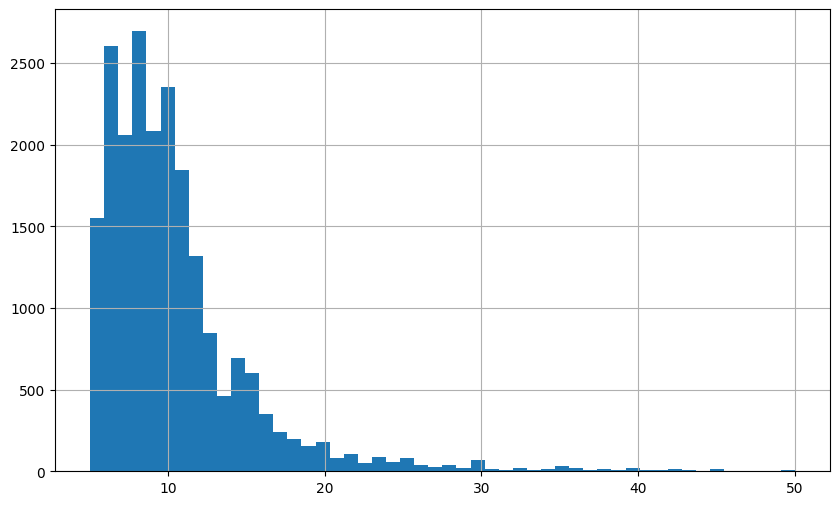

In [94]:
data['kitchen_area'].hist(bins=50, figsize=(10, 6));

Медиана значений площадей кухонь равна 9,1 кв.м., среднее значение - 10,4 кв.м, первый квартиль - 7 кв.м, третий - 12.

При этом график так же имеет несколько всплесков, говорящих всё о той же типовой застройке со стандартными размерами кухонь.

##### Изучим цены объектов

In [95]:
data['last_price'].describe()

count    2.115000e+04
mean     6.010568e+06
std      4.809878e+06
min      4.300000e+05
25%      3.500000e+06
50%      4.700000e+06
75%      6.760000e+06
max      5.000000e+07
Name: last_price, dtype: float64

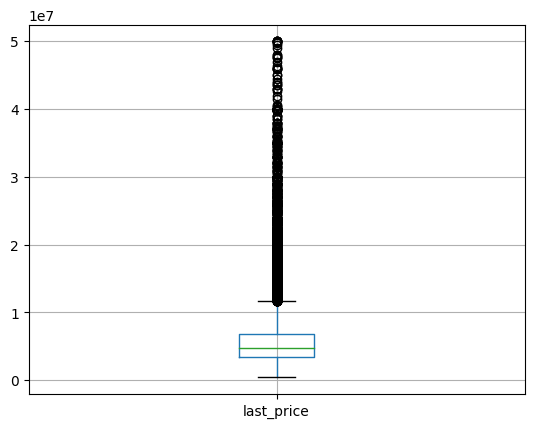

In [96]:
data.boxplot('last_price');

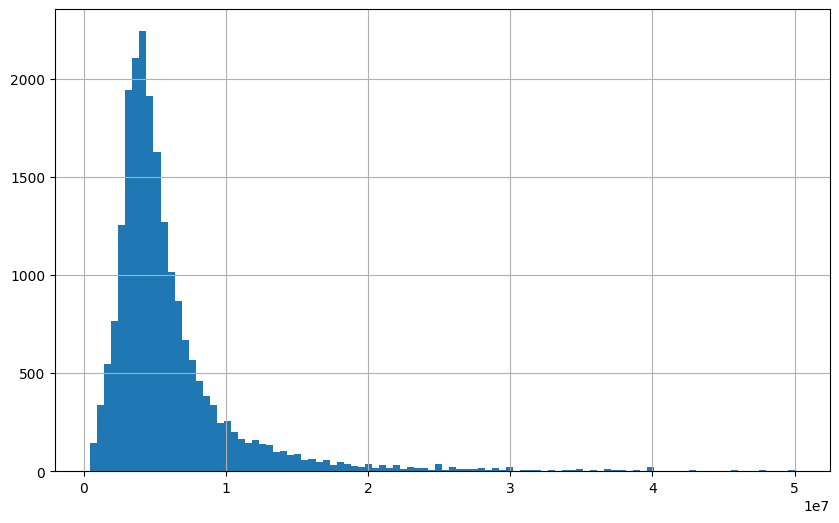

In [97]:
data['last_price'].hist(bins=100, figsize=(10, 6));

Медиана цен продаваемых квартир равна 4,7 млн, среднее значение - 6 млн, первый квартиль - 3,5 млн, третий - 6,8. Стандартное отклонение довольно большое и соизмеримо с медианным значением из-за большого "хвоста", который хорошо видно на гистограмме - небольшого числа очень дорогих квартир с ценой более 20 млн. При этом на графике ярко выражено одно пиковое значение в районе медианы, что соответствует нормальному распределению цен.

##### Изучим количество комнат

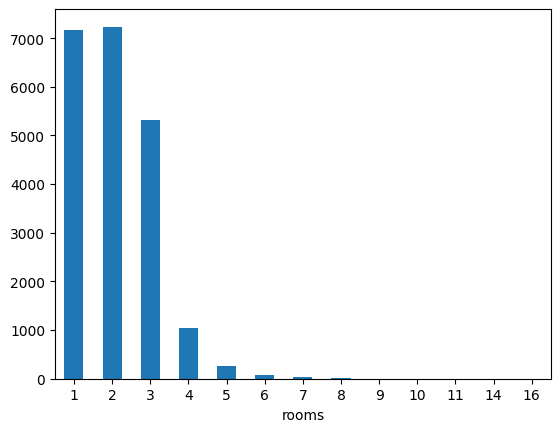

In [98]:
data.groupby(by='rooms')['rooms'].count().plot(kind='bar', rot=0);

"Однушек" и "двушек" в выборке больше всего. Немного меньше - "трешек". Квартиры с количеством комнат больше четырех занимают незначительную долю в объявлениях.

##### Изучим высоту потолков

In [99]:
data['ceiling_height'].describe()

count    21150.000000
mean         2.694544
std          0.211816
min          2.250000
25%          2.600000
50%          2.650000
75%          2.700000
max          4.800000
Name: ceiling_height, dtype: float64

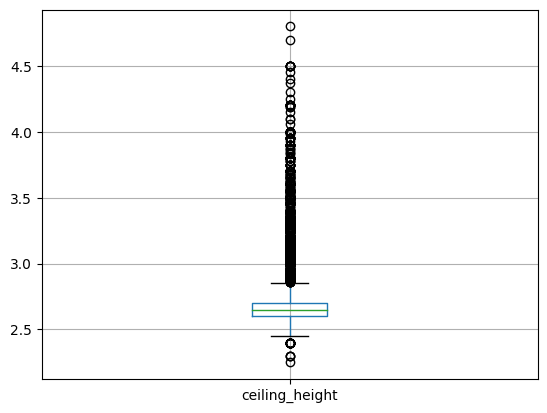

In [100]:
data.boxplot('ceiling_height');

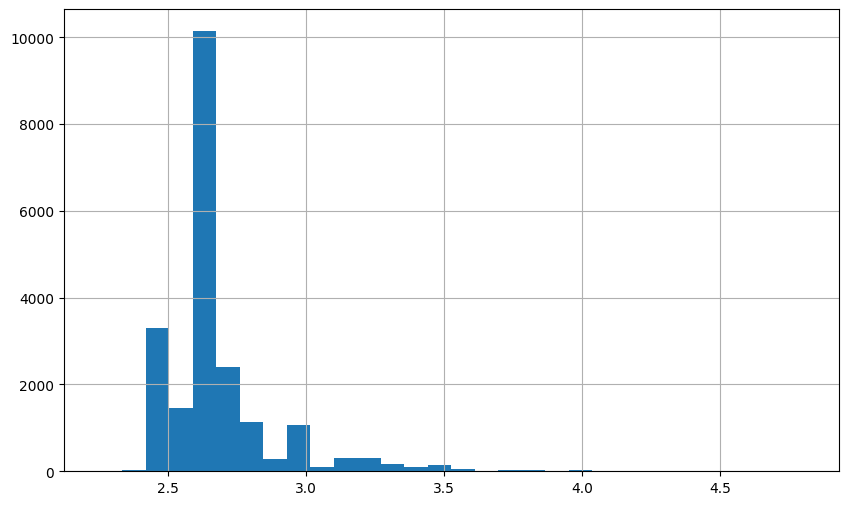

In [101]:
data['ceiling_height'].hist(bins=30, figsize=(10, 6));

График имеет ярко выраженный всплеск в районе медианного значения, равного 2,65 м.  Это вызвано тем, что в исходных данных было порядка 30% пропусков, которые были заполнены медианными значениями. В результате этого итоговые значения могут быть искажены. Для дальнейшего анализа требуется изучить причины появления большого числа пропусков в этом поле.

##### Изучим данные об этажах квартир

In [102]:
data['floor'].describe()

count    21150.000000
mean         5.871064
std          4.845699
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

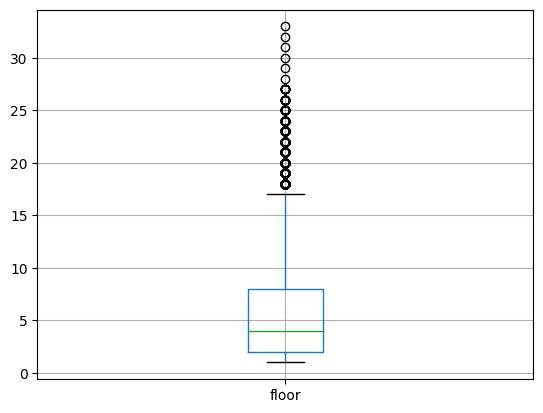

In [103]:
data.boxplot('floor');

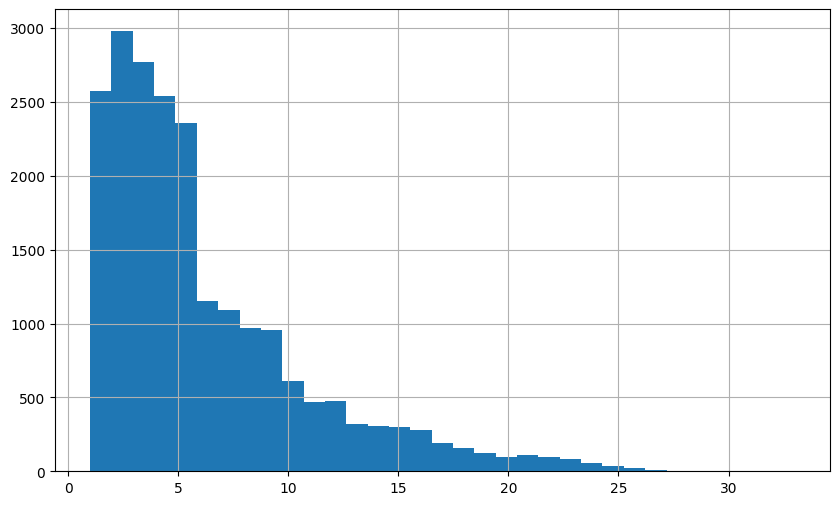

In [104]:
data['floor'].hist(bins=(data['floor'].nunique()), figsize=(10, 6));

Больше всего квартир продается на нижних этажах, так как квартиры на низких этажах продают и в малоэтажной застройке, и в высотной. Заметны резкие уменьшения числа продаваемых квартир после 5 и 9 этажей. Это связано с распросраненностью домов соответствующей этажности.

##### Изучим тип этажа

In [105]:
(
data
    .pivot_table(index='floor_type', values='floor', aggfunc='count')
    .rename(columns={'floor': 'floor_type'})
)

floor_type
floor_type            
first             2576
last              2977
other            15597

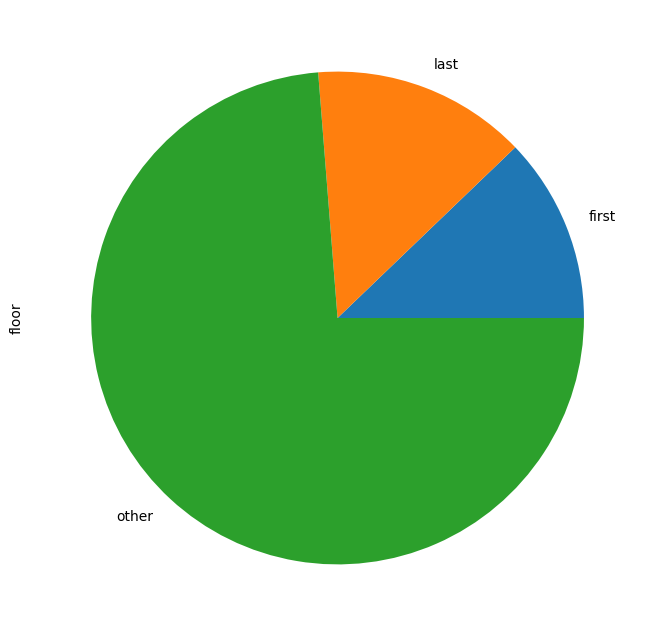

In [106]:
(
data
    .groupby(by='floor_type')['floor']
    .count()
    .plot(kind='pie', figsize=(8, 8))
);

Большинство квартир расположены на средних этажах. Квартир на первом и последнем этажах примерно равное количество.

##### Изучим данные об этажности домов

In [107]:
data['floors_total'].describe()

count    21112.000000
mean        10.624479
std          6.525606
min          1.000000
25%          5.000000
50%          9.000000
75%         15.000000
max         37.000000
Name: floors_total, dtype: float64

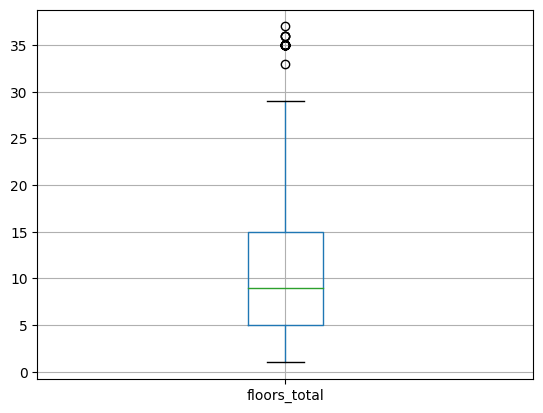

In [108]:
data.boxplot('floors_total');

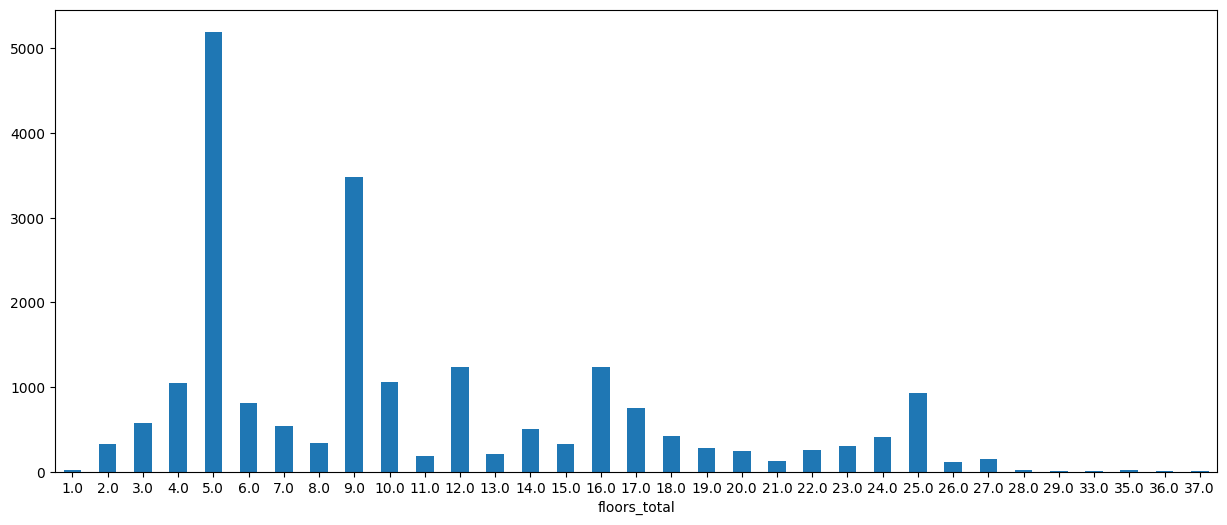

In [109]:
data.groupby(by='floors_total')['floors_total'].count().plot(kind='bar', rot=0, figsize=(15, 6));

В данных имеются всплески значений определенной этажности - 5, 9, 12, 16 и 25 этажей. Причина - типовые проекты застройки.

##### Изучим расстояние до центра города в метрах

In [110]:
data['city_centers_nearest'].describe()

count    16385.000000
mean     14272.020629
std       8604.561218
min        181.000000
25%       9436.000000
50%      13140.000000
75%      16293.000000
max      65968.000000
Name: city_centers_nearest, dtype: float64

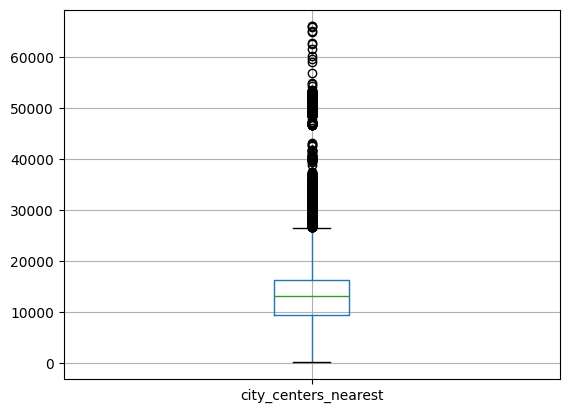

In [111]:
data.boxplot('city_centers_nearest');

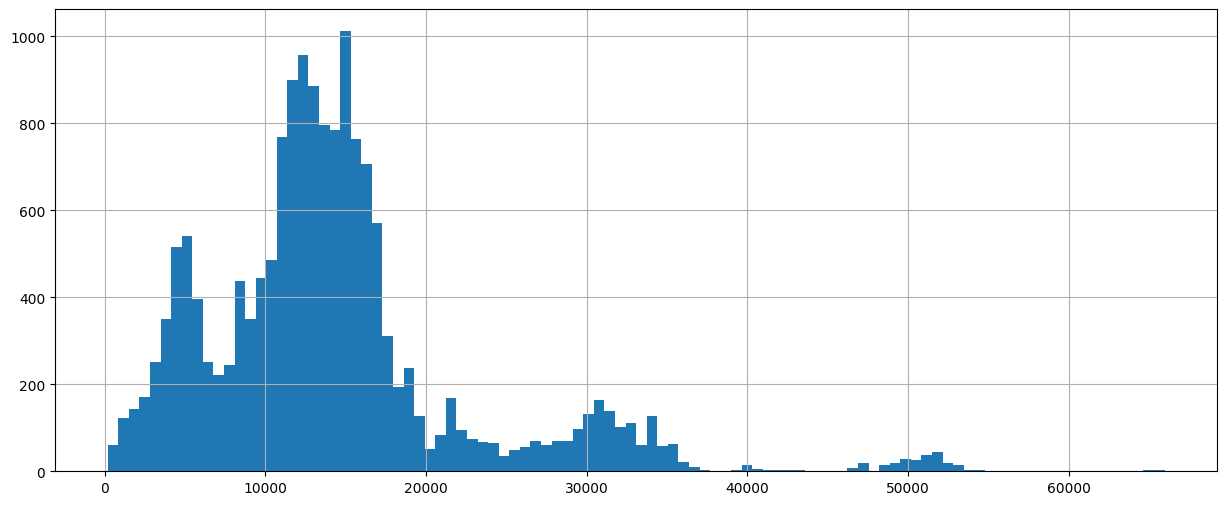

In [112]:
data['city_centers_nearest'].hist(bins=100, figsize=(15, 6));

Половина продаваемых квартир расположены на расстоянии от 10000 до 16000 метров от центра города. При этом имеются явные всплески в районе 5000, 15000, 22000, 31000 и 53000, что можно объяснить сгруппированностью жилых массивов на указанных расстояних от центра.

##### Изучим расстояние до ближайшего аэропорта

In [113]:
data['airports_nearest'].describe()

count    16366.000000
mean     28829.337957
std      12646.575344
min       6450.000000
25%      18539.750000
50%      26786.000000
75%      37350.250000
max      84869.000000
Name: airports_nearest, dtype: float64

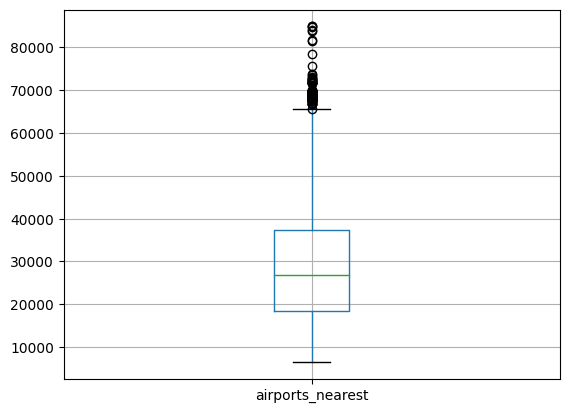

In [114]:
data.boxplot('airports_nearest');

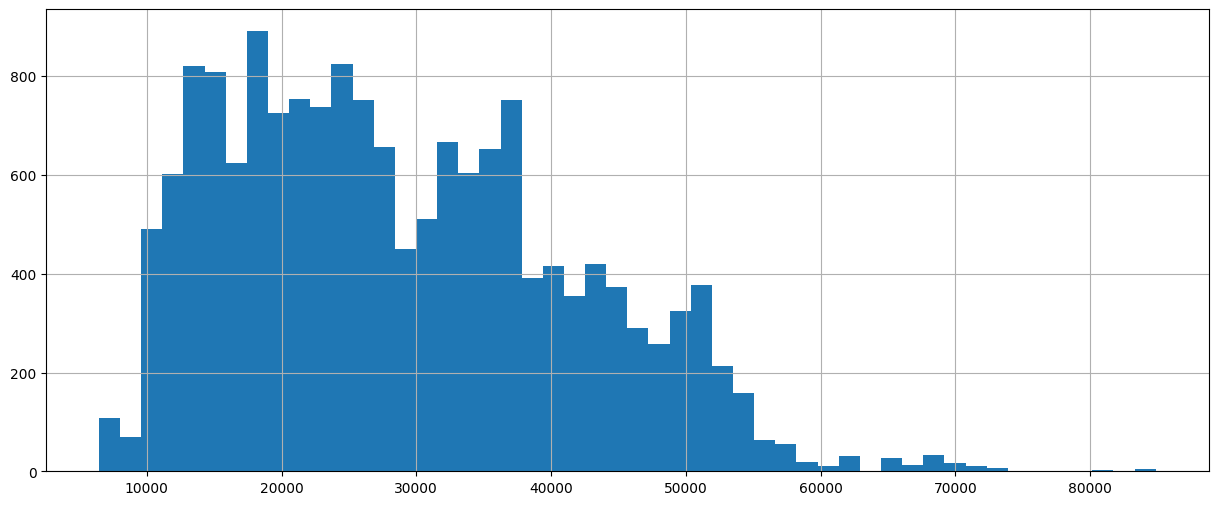

In [115]:
data['airports_nearest'].hist(bins=50, figsize=(15, 6));

Половина продаваемых квартир расположены на расстоянии от 18000 до 38000 метров от ближайшего аэропорта. Также имеется всплеск в районе 35000, что можно объяснить нахождением на указанном расстоянии большого числа жилых массивов.

##### Изучим расстояние до ближайшего парка

In [116]:
data['parks_nearest'].describe()

count    7254.000000
mean      489.432589
std       338.902533
min         1.000000
25%       288.000000
50%       455.000000
75%       611.000000
max      3190.000000
Name: parks_nearest, dtype: float64

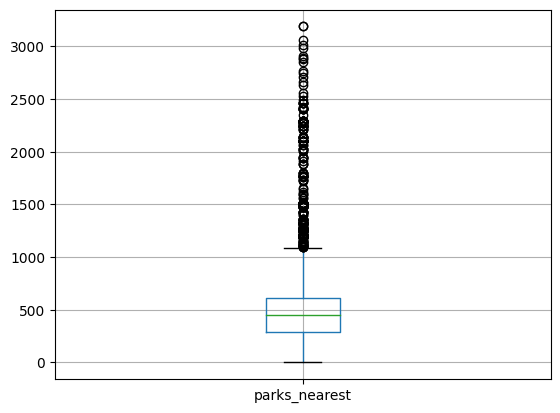

In [117]:
data.boxplot('parks_nearest');

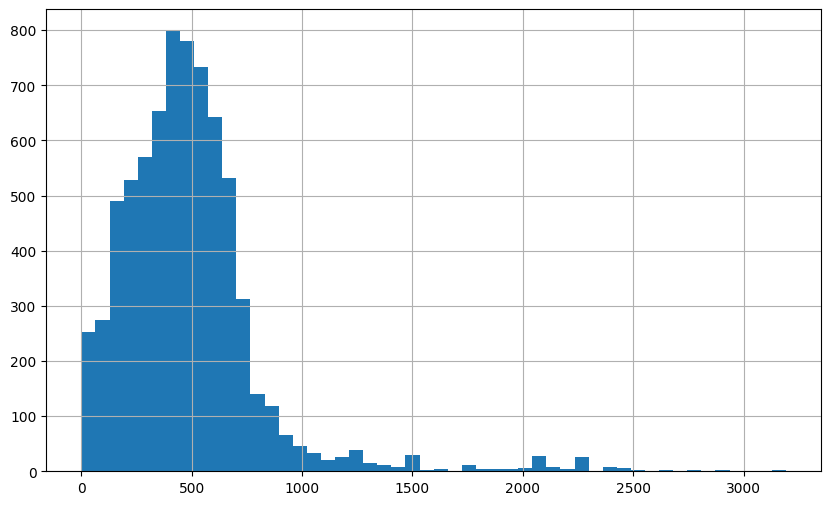

In [118]:
data['parks_nearest'].hist(bins=50, figsize=(10, 6));

Большая часть продаваемых квартир расположены на расстоянии от 200 до 700 метров до ближайшего парка.

##### Изучим день и месяц публикации объявления

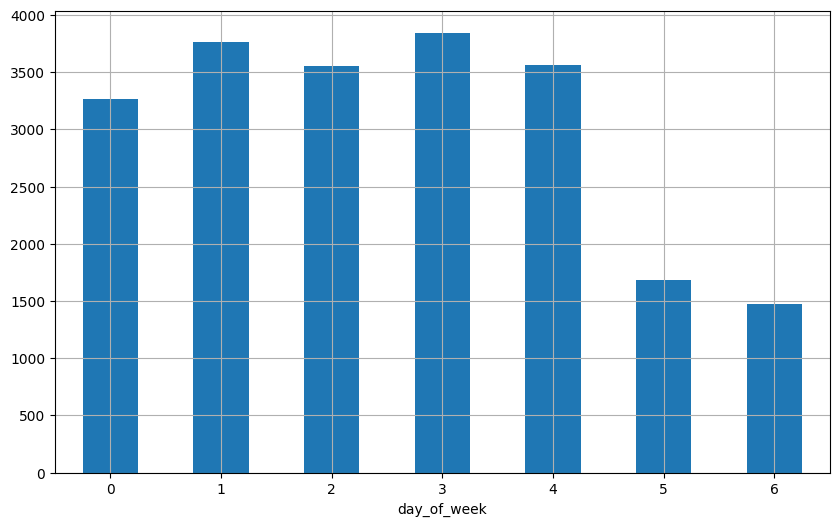

In [119]:
(
data
    .groupby(by='day_of_week')['day_of_week']
    .count()
    .plot(kind='bar', figsize=(10, 6), grid=True, rot=0)
);

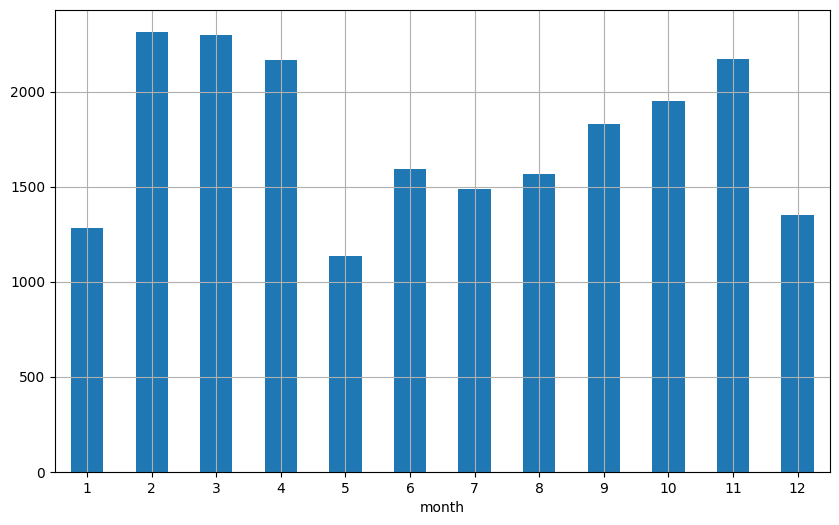

In [120]:
(
data
    .groupby(by='month')['month']
    .count()
    .plot(kind='bar', figsize=(10, 6), grid=True, rot=0)
);

Судя по графикам, больше всего объявлений публикуют по вторникам и четвергам, чуть меньше - по средам и пятницам. В выходные активность минималная.

По месяцам минимальная активность публикации новых объявлений - в мае, что, скорее всего, связано с длинными майскими празниками и началом сезона отпусков. Затем в июне идет всплеск актиности и с июля по ноябрь активность постепенно увиличивается дальше. Затем идет спад активности в декабре и январе. Наибольшая активность наблюдается с февраля по апрель.

#### Изучим данные об экспозиции объявлений

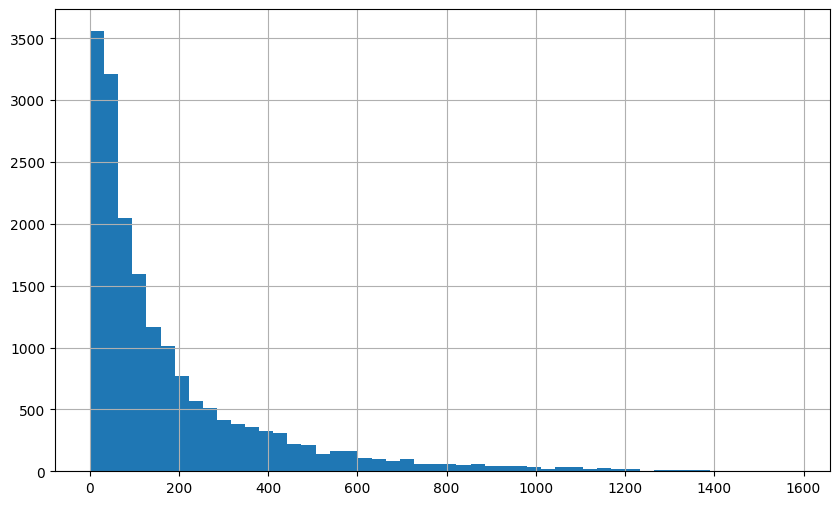

In [121]:
data['days_exposition'].hist(bins=50, figsize=(10,6));

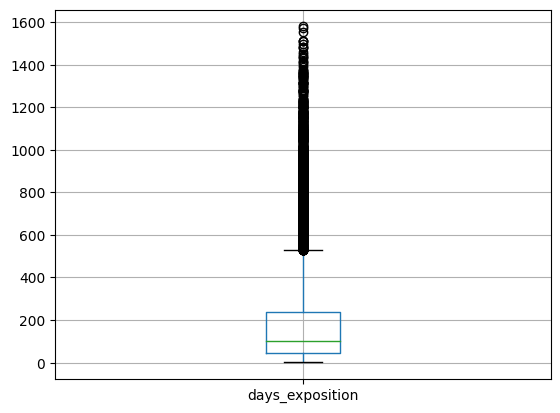

In [122]:
data.boxplot('days_exposition');

In [123]:
data['days_exposition'].describe()

count    18218.000000
mean       184.909430
std        221.987402
min          1.000000
25%         45.000000
50%        101.000000
75%        238.000000
max       1580.000000
Name: days_exposition, dtype: float64

Рассмотрим ближе самые быстрые продажи и самые частые значения экспозиций объявлений.

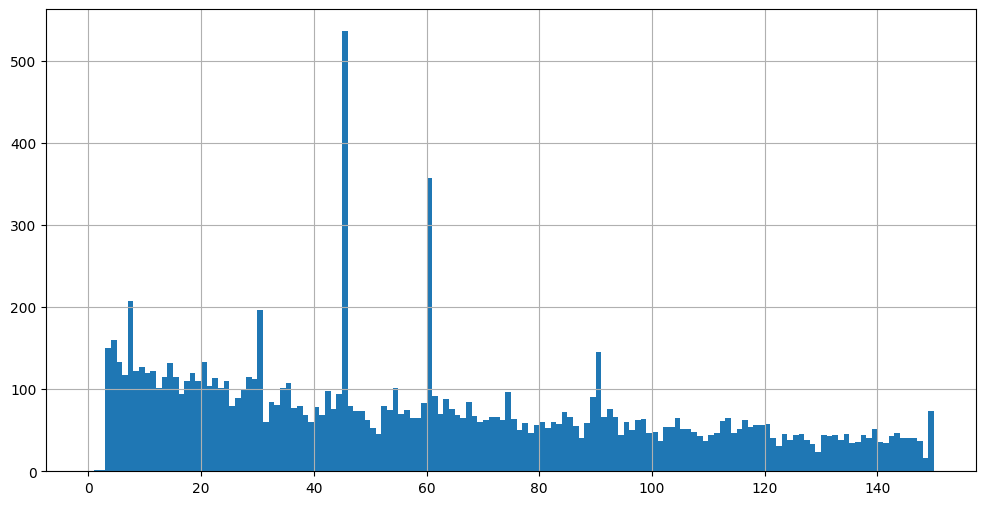

In [124]:
data['days_exposition'].hist(bins=150, range=(0, 150), figsize=(12,6));

In [125]:
data['days_exposition'].value_counts().head(15)

45.0    536
60.0    357
7.0     208
30.0    196
4.0     160
3.0     150
90.0    145
5.0     133
20.0    133
14.0    132
9.0     127
11.0    122
8.0     122
18.0    120
10.0    120
Name: days_exposition, dtype: int64

Среднее время размещения объявления - 185 дней. При этом половина всех сделок закрывается за 101 день или быстрее. Четверть всех продаж происходит в срок до 45 дней. Больше всего сделок закрывают в первые две недели после размещения объявления.

Чаще всего объявления снимают с публикации на 45й день. Также видна активность на 30й, 60й и 90й дни, что, скорее всего, связано с особенностью работы платформы или реэлторских агенств, размещающих на ней свои объявления.

Необычайно долгими можно считать продажи продолжительностью более 500 дней, так как примерно по этому числу проходит верхняя граница статистически значимой выбрки.

#### Изучим связь цены с характеристиками объекта

##### Изучим связь цены с общей площадью квартиры.

In [126]:
print('Коэффициент корреляции Пирсона:', 
      data['total_area'].corr(data['last_price']))

Коэффициент корреляции Пирсона: 0.7781227040389296


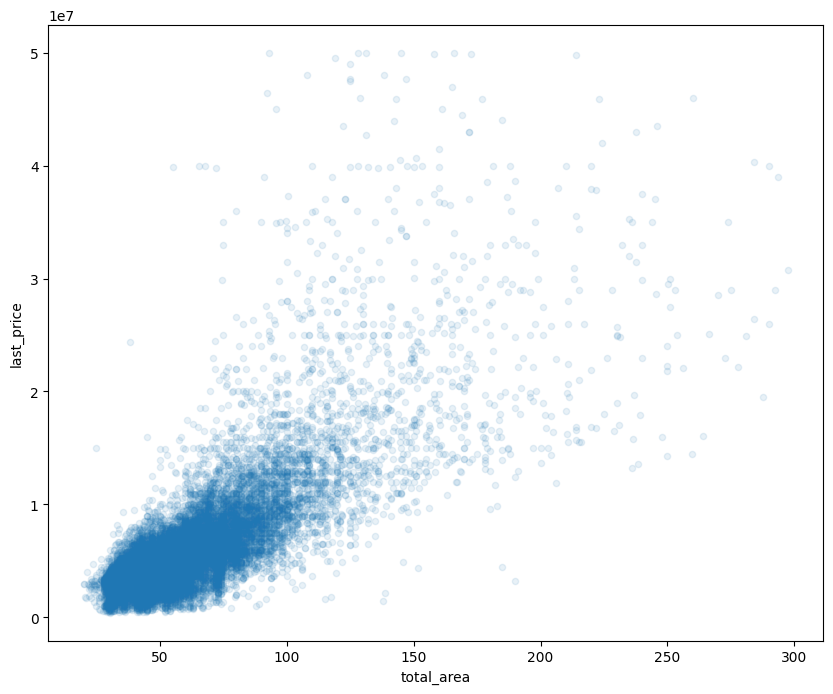

In [127]:
data.plot(kind='scatter', 
          x='total_area', 
          y='last_price', 
          figsize=(10, 8), 
          alpha=0.1);

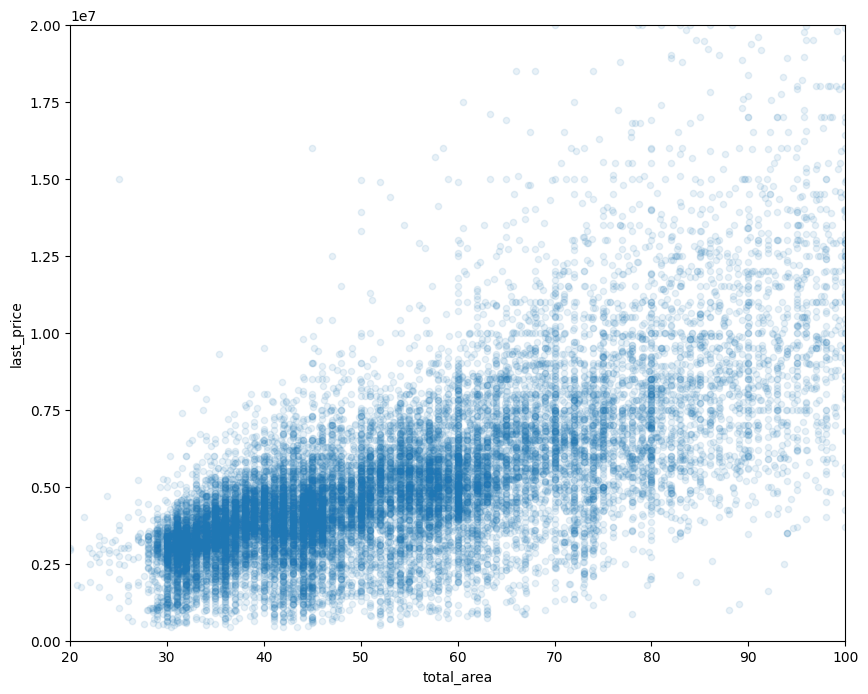

In [128]:
data.plot(kind='scatter', 
          x='total_area', 
          y='last_price', 
          xlim=(20, 100), 
          ylim=(0, 20000000), 
          figsize=(10, 8),
          alpha=0.1);

Заметна общая тенденция - с увеличением общей площади увеличивается и средняя цена предложения. Коэффициент корреляции между ценой и общей площадью равен 0,78. Однако, можно заметить, что квартиры с одной и той же площадью выставляются в очень широком диапазоне цен. Причем с увеличение площади увеличивается и разброс цен. Для более точного исследования рассмотрим отдельно предложения в Санкт-Петербурге и области.

In [129]:
print('Коэффициент корреляции Пирсона (Санкт-Петергбург):', 
      data[data['locality_name'] == 'Санкт-Петербург']['total_area']
      .corr(data['last_price']))

Коэффициент корреляции Пирсона (Санкт-Петергбург): 0.79596211215653


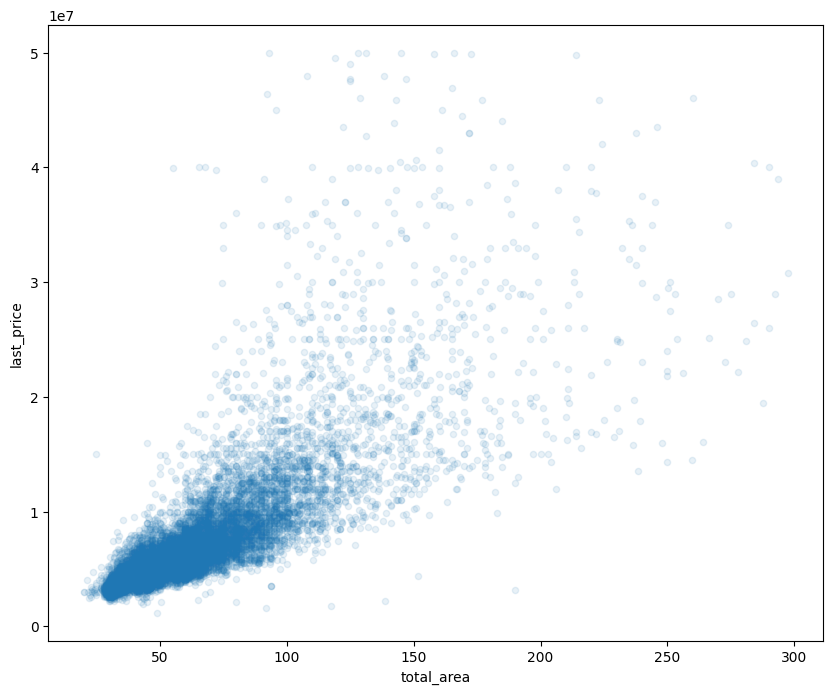

In [130]:
data[data['locality_name'] == 'Санкт-Петербург'].plot(kind='scatter', 
          x='total_area', 
          y='last_price', 
          figsize=(10, 8), 
          alpha=0.1);

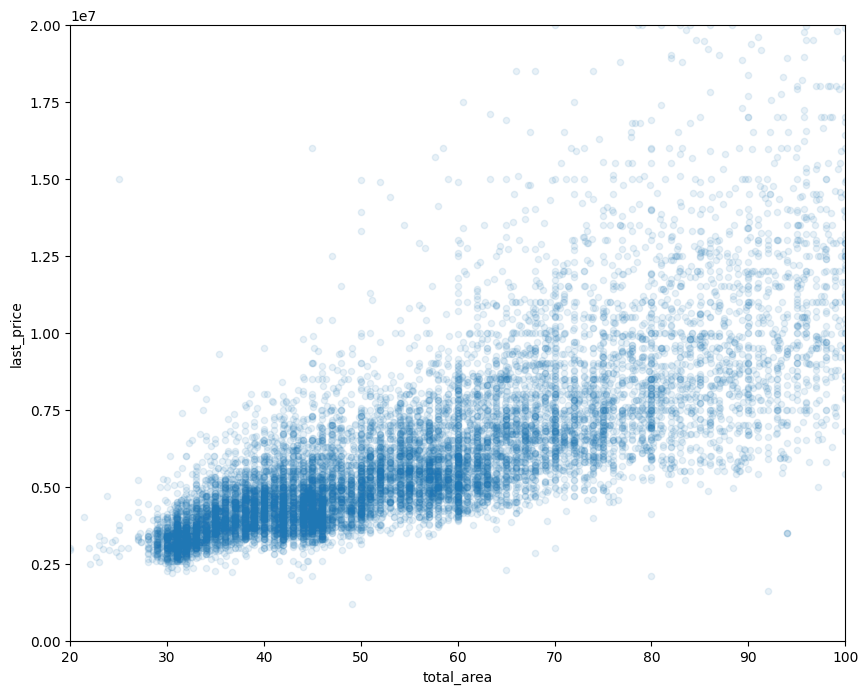

In [131]:
data[data['locality_name'] == 'Санкт-Петербург'].plot(kind='scatter', 
          x='total_area', 
          y='last_price', 
          figsize=(10, 8), 
          alpha=0.1, 
          xlim=(20, 100), 
          ylim=(0, 20000000));

Для квартир, продаваемых в Санкт-Петербурге коэффициент корреляции немного выше, чем в целом по области, и составляет 0,8. Также заметно, что цена растет с увеличением общей площади. Однако, разброс цен при одинаквых площадях имеет место так же, как и по всей области.

In [132]:
print('Коэффициент корреляции Пирсона (без Санкт-Петергбурга):', 
      data[(data['locality_name'] != 'Санкт-Петербург') 
           & (data['locality_name'] != 'Неизвестно')]['total_area']
      .corr(data['last_price']))

Коэффициент корреляции Пирсона (без Санкт-Петергбурга): 0.6934416820770753


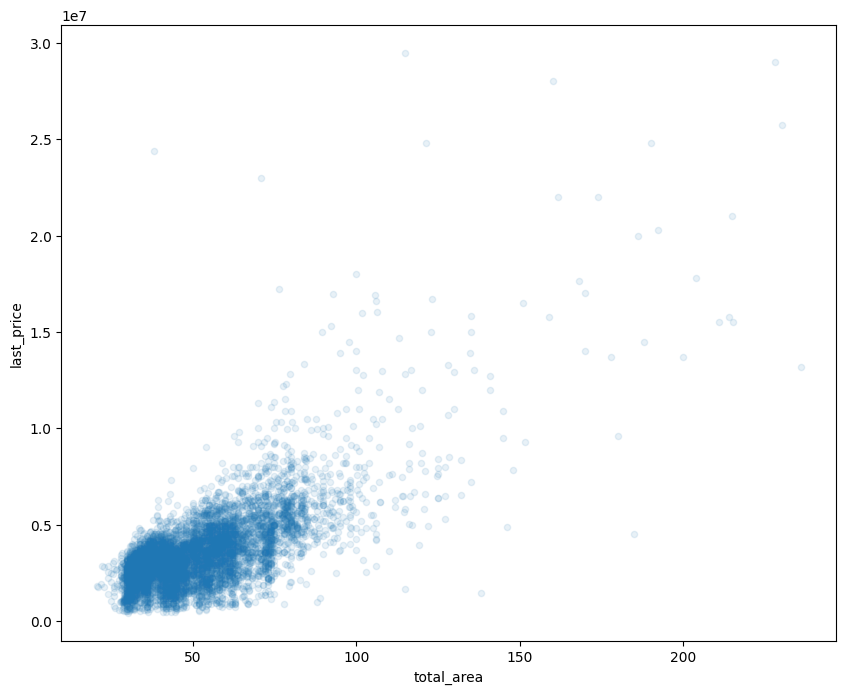

In [133]:
(
data[(data['locality_name'] != 'Санкт-Петербург') 
           & (data['locality_name'] != 'Неизвестно')]
    .plot(kind='scatter', 
          x='total_area', 
          y='last_price', 
          figsize=(10, 8), 
          alpha=0.1)
);

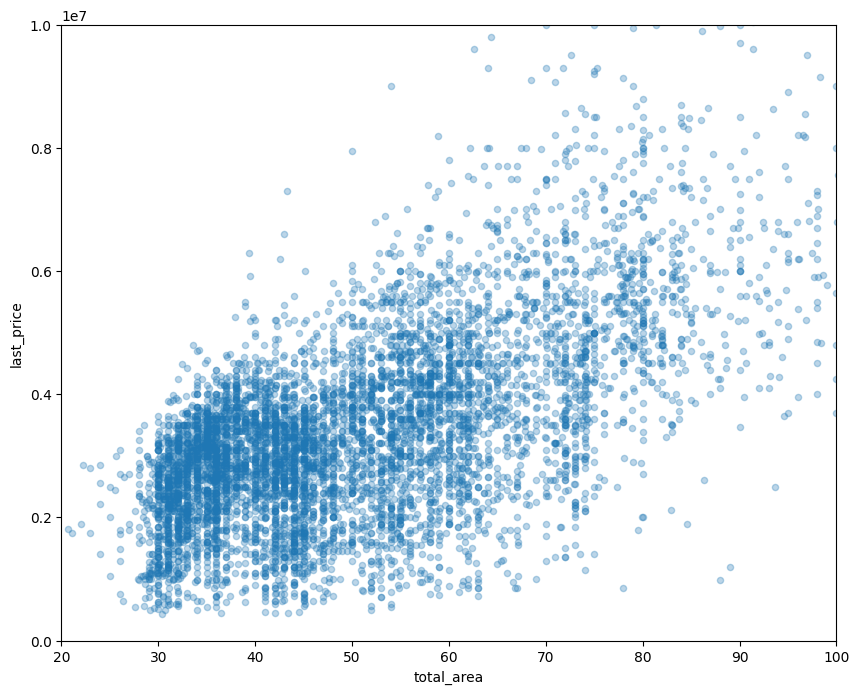

In [134]:
(
data[(data['locality_name'] != 'Санкт-Петербург') 
           & (data['locality_name'] != 'Неизвестно')]
    .plot(kind='scatter', 
          x='total_area', 
          y='last_price', 
          figsize=(10, 8),
          xlim=(20, 100), 
          ylim=(0, 10000000), 
          alpha = 0.3)
);

Корреляция цен квартир с их общей площадью в области ниже, чем в Санкк-Петербурге. Разброс цен у квартир с одинаковой площадью такой же сильный.

##### Изучим связь цены с жилой площадью квартиры.

In [135]:
print('Коэффициент корреляции Пирсона:', 
      data['living_area'].corr(data['last_price']))

Коэффициент корреляции Пирсона: 0.6787280989715567


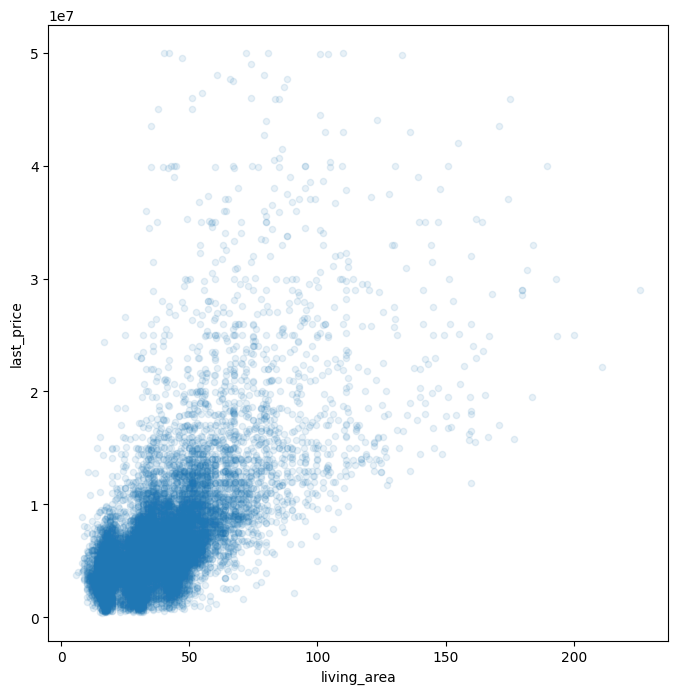

In [136]:
data.plot(kind='scatter', 
          x='living_area', 
          y='last_price', 
          figsize=(8, 8), 
          alpha=0.1);

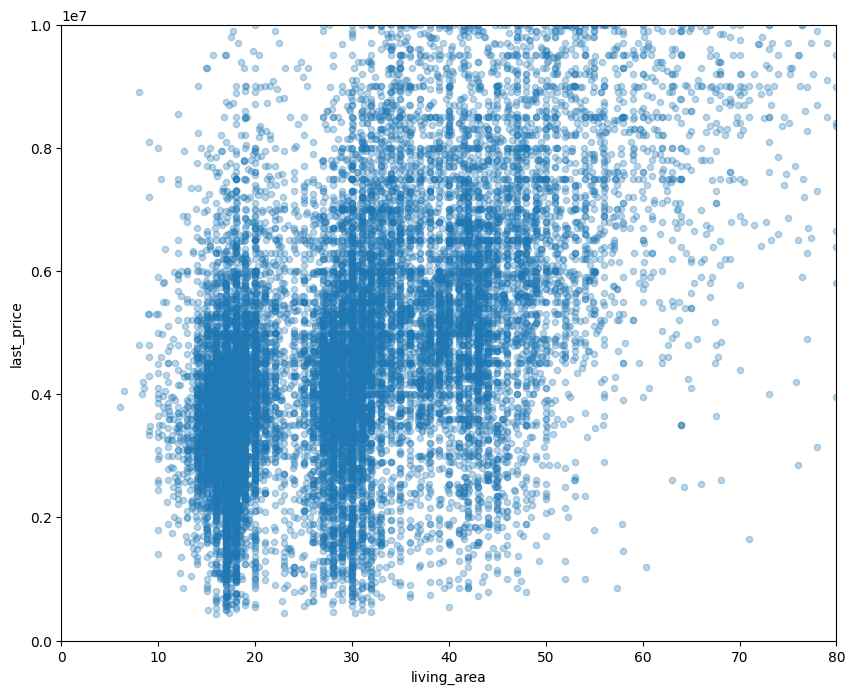

In [137]:
data.plot(kind='scatter', 
          x='living_area', 
          y='last_price', 
          figsize=(10, 8),
          xlim=(0, 80), 
          ylim=(0, 10000000),
          alpha=0.3);

Цена квартир коррелирует с жилой площадью меньше, чем с общей (коэффециент Пирсона - 0,68).

Рассмотрим отдельно Санкт-Петербург и область.

In [138]:
print('Коэффициент корреляции Пирсона (Санкт-Петергбург):', 
      data[data['locality_name'] == 'Санкт-Петербург']['living_area']
      .corr(data['last_price']))

Коэффициент корреляции Пирсона (Санкт-Петергбург): 0.6974166290144418


In [139]:
print('Коэффициент корреляции Пирсона (без Санкт-Петергбурга):', 
      data[(data['locality_name'] != 'Санкт-Петербург') 
           & (data['locality_name'] != 'Неизвестно')]['total_area']
      .corr(data['last_price']))

Коэффициент корреляции Пирсона (без Санкт-Петергбурга): 0.6934416820770753


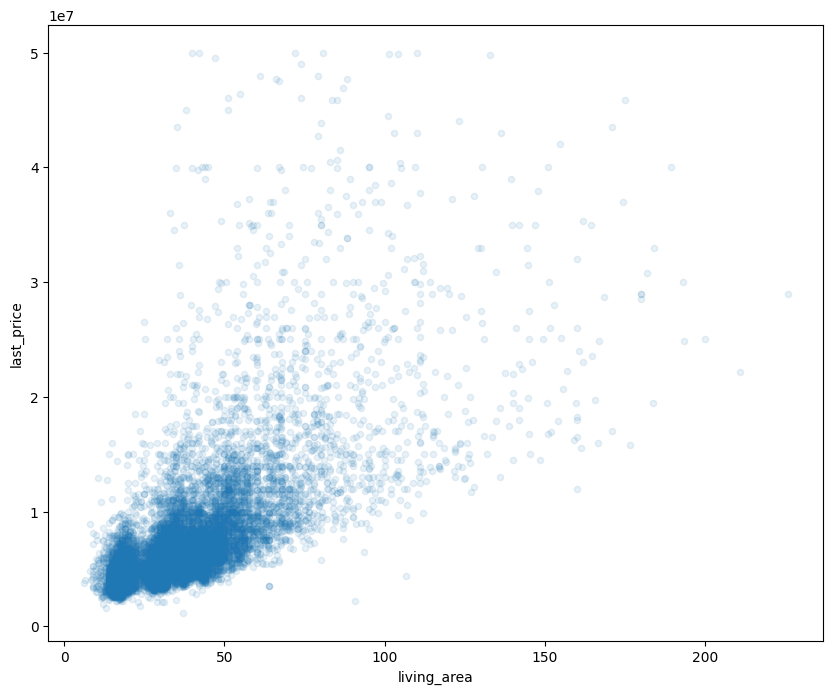

In [140]:
data[data['locality_name'] == 'Санкт-Петербург'].plot(kind='scatter', 
          x='living_area', 
          y='last_price', 
          figsize=(10, 8), 
          alpha=0.1);

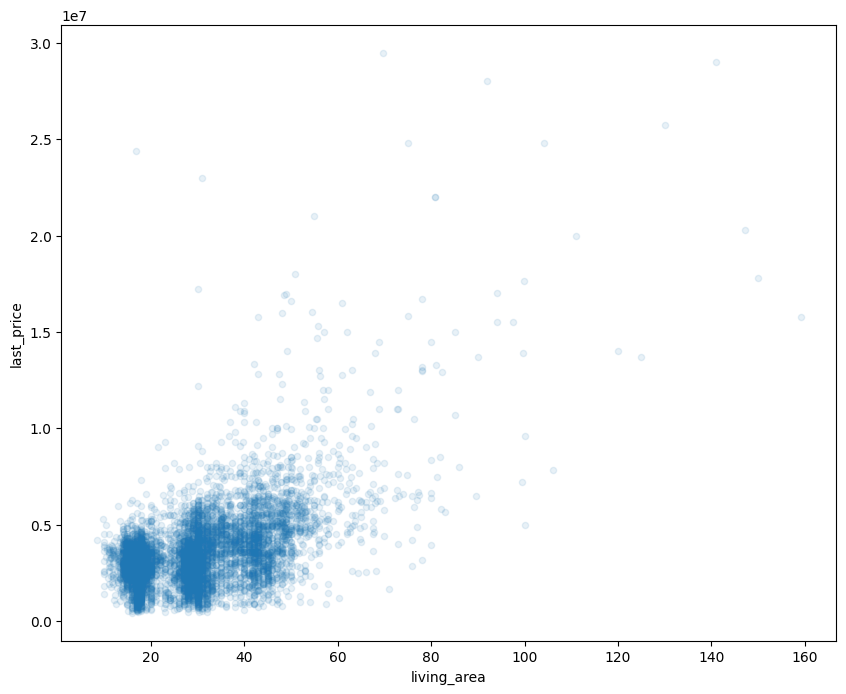

In [141]:
(
data[(data['locality_name'] != 'Санкт-Петербург') 
           & (data['locality_name'] != 'Неизвестно')]
    .plot(kind='scatter', 
          x='living_area', 
          y='last_price', 
          figsize=(10, 8), 
          alpha=0.1)
);

В обоих случая (для Санкт-Петербурга и для области без учета Санкт-Петербурга) коэффициент корреляции между ценой и жилой площадью оказался выше, чем в среднем - 0,7 и 0,69, соответственно (средний - 0,68). 

Цена растет с увеличением жилой площади. Однако, все так же имеет место сильнрый разброс цен при одинаковых жилых площадях. 

##### Изучим связь цены с площадью кухни.

In [142]:
print('Коэффициент корреляции Пирсона:', 
      data['kitchen_area'].corr(data['last_price']))

Коэффициент корреляции Пирсона: 0.5933368811448602


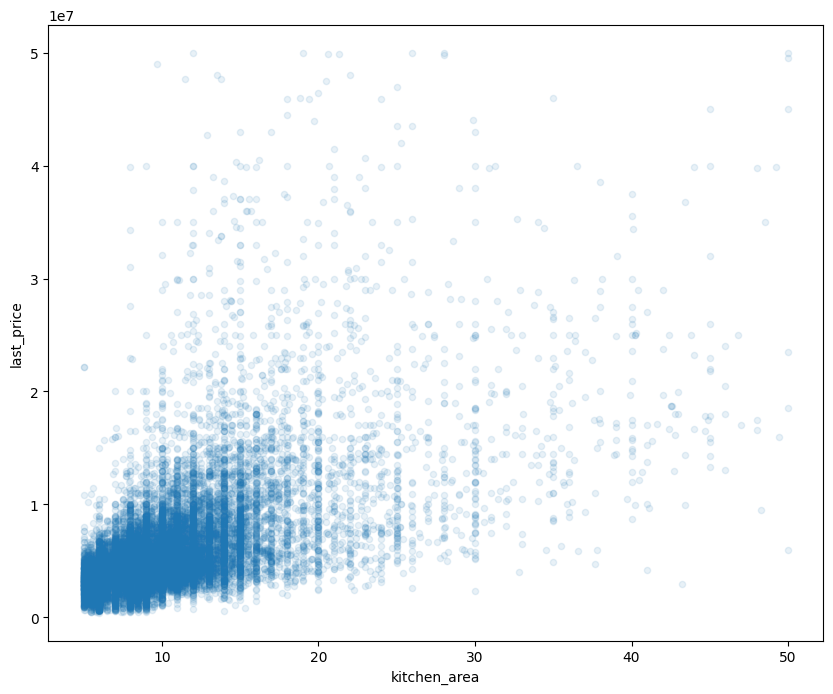

In [143]:
data.plot(kind='scatter', 
          x='kitchen_area', 
          y='last_price', 
          figsize=(10, 8), 
          alpha=0.1);

In [144]:
print('Коэффициент корреляции Пирсона (Санкт-Петергбург):', 
      data[data['locality_name'] == 'Санкт-Петербург']['kitchen_area']
      .corr(data['last_price']))

Коэффициент корреляции Пирсона (Санкт-Петергбург): 0.604527619382121


In [145]:
print('Коэффициент корреляции Пирсона (без Санкт-Петергбурга):', 
      data[(data['locality_name'] != 'Санкт-Петербург') 
           & (data['locality_name'] != 'Неизвестно')]['kitchen_area']
      .corr(data['last_price']))

Коэффициент корреляции Пирсона (без Санкт-Петергбурга): 0.5421546007486499


С площадью кухнии цена квартиры связана еще слабее, чем с общей площадью. Коэффициент корреляции в среднем по выборке - 0,59, в Санкт-Петербурге чуть выше - 0,6, в ЛО ниже - 0,54.

##### Изучим связь цены с количеством комнат.

In [146]:
print('Коэффициент корреляции Пирсона:', 
      data['rooms'].corr(data['last_price']))

Коэффициент корреляции Пирсона: 0.49877024914970086


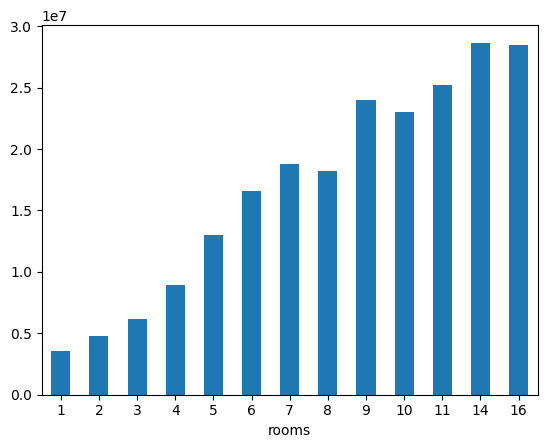

In [147]:
data.groupby(by='rooms')['last_price'].median().plot(kind='bar', rot=0);

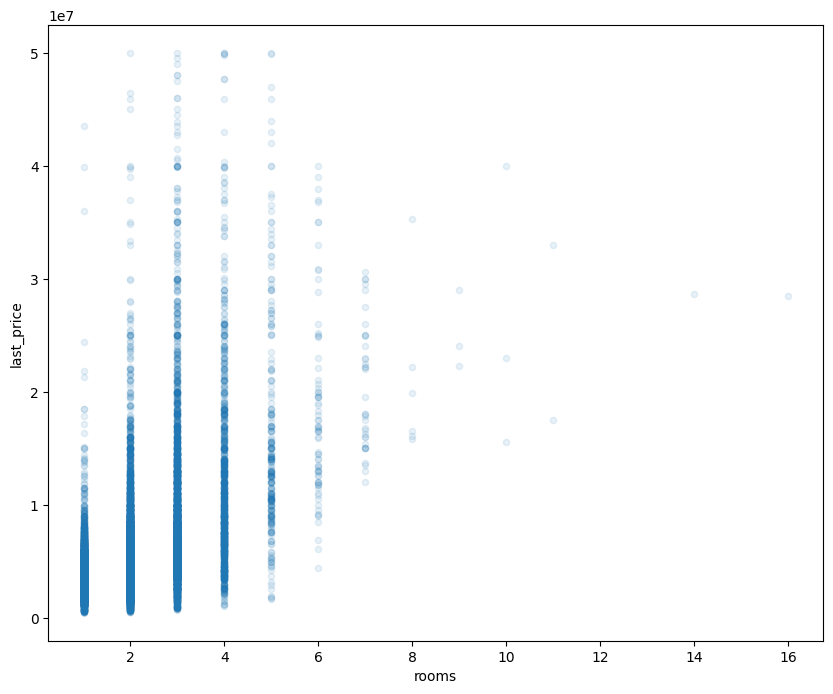

In [148]:
data.plot(kind='scatter', 
          x='rooms', 
          y='last_price', 
          figsize=(10, 8), 
          alpha=0.1);

Прослеживается прямая зависимость медианной цены от количества комант в продаваемой квартире. Однако коэффициент корреляции составляет всего 0,5 по причине большого разброса цен на квартиры с одинаковым количеством комнат.

##### Изучим связь цены с типом этажа.

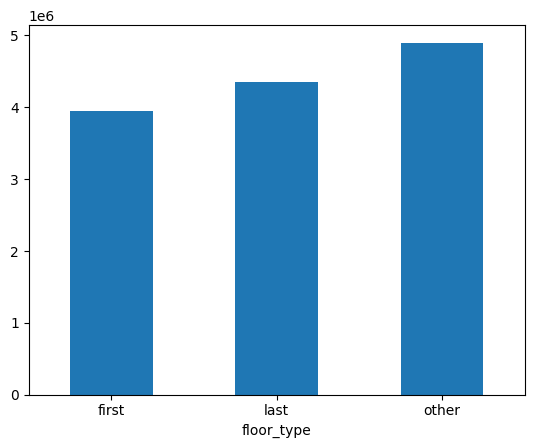

In [149]:
data.groupby(by='floor_type')['last_price'].median().plot(kind='bar', rot=0);

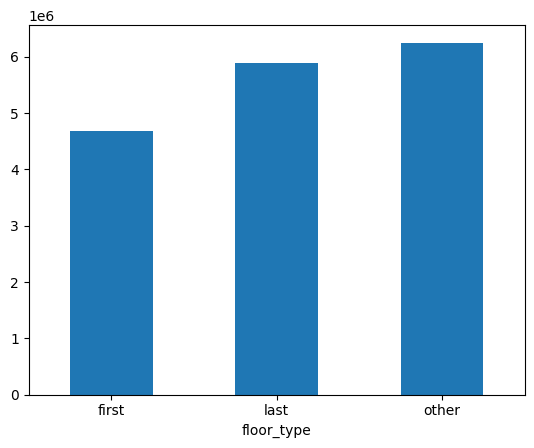

In [150]:
data.groupby(by='floor_type')['last_price'].mean().plot(kind='bar', rot=0);

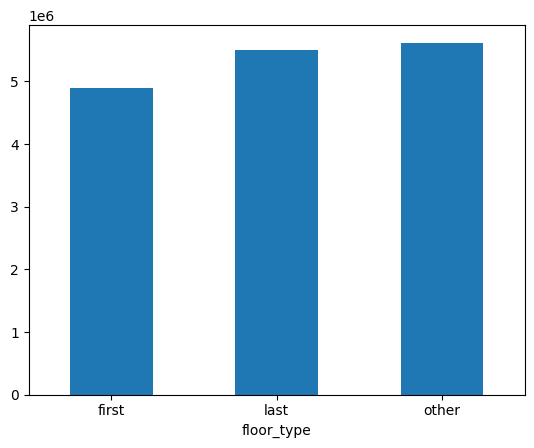

In [151]:
(
data[data['locality_name'] == 'Санкт-Петербург']
    .groupby(by='floor_type')['last_price']
    .median()
    .plot(kind='bar', rot=0)
);

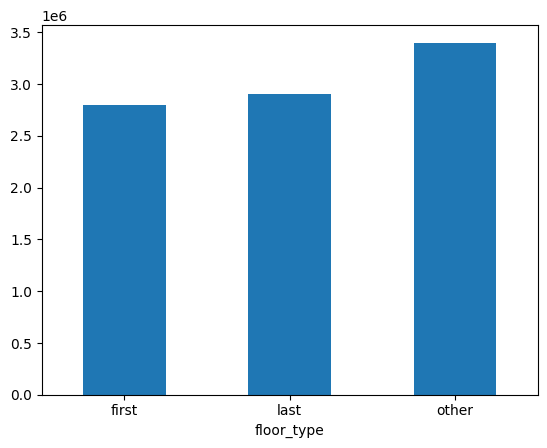

In [152]:
(
data[(data['locality_name'] != 'Санкт-Петербург') 
     & (data['locality_name'] != 'Неизвестно')]
    .groupby(by='floor_type')['last_price']
    .median()
    .plot(kind='bar', rot=0)
);

В целом средняя и медианная цена зависят от этажа. Самые дешевые квартиры - на первом этаже, а средние этажи ценятся больше крайних. При этом в Санкт-Петербурге нет большой разницы между медианными ценами квартир на последних и средних этажей, а в ЛО отсутствует большая разница в ценах между первыми и средними этажами.

##### Изучим связь цены с датой размещения.

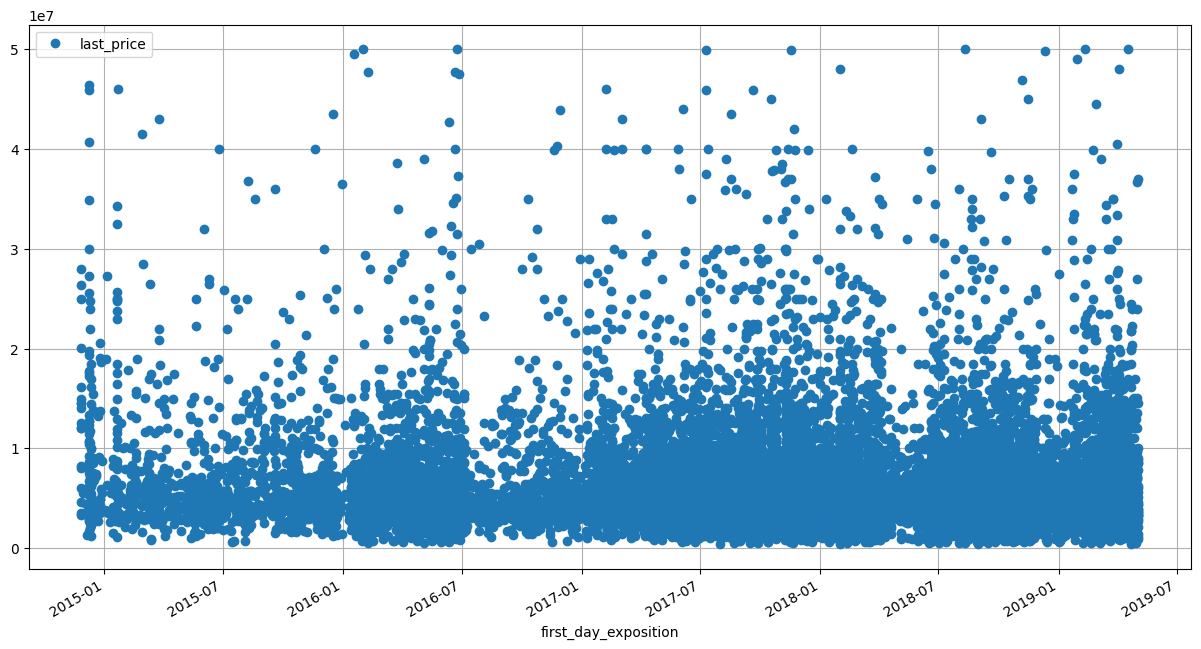

In [153]:
data.plot(x='first_day_exposition', y='last_price', 
          style='o', grid=True, figsize=(15, 8));

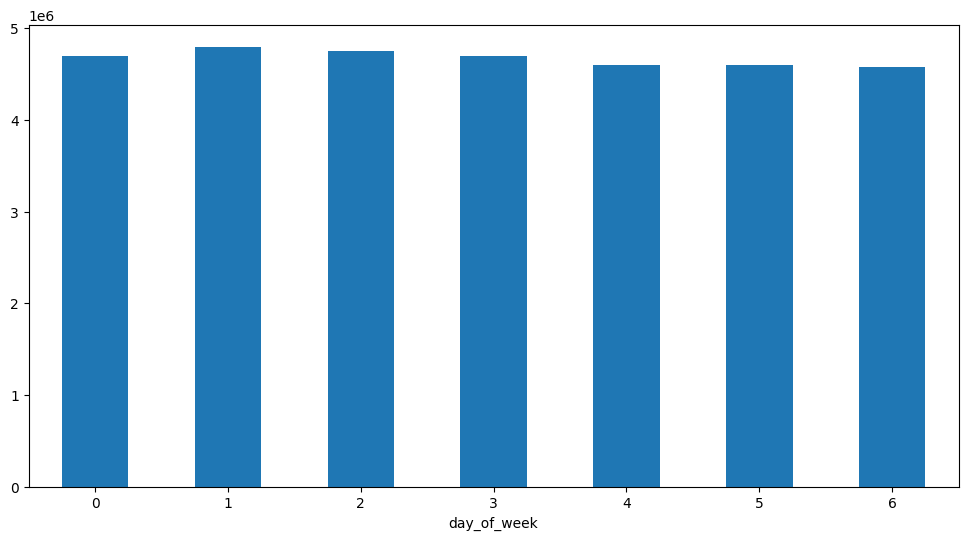

In [154]:
data.groupby(by='day_of_week')['last_price'].median().plot(kind='bar', figsize=(12, 6), rot=0);

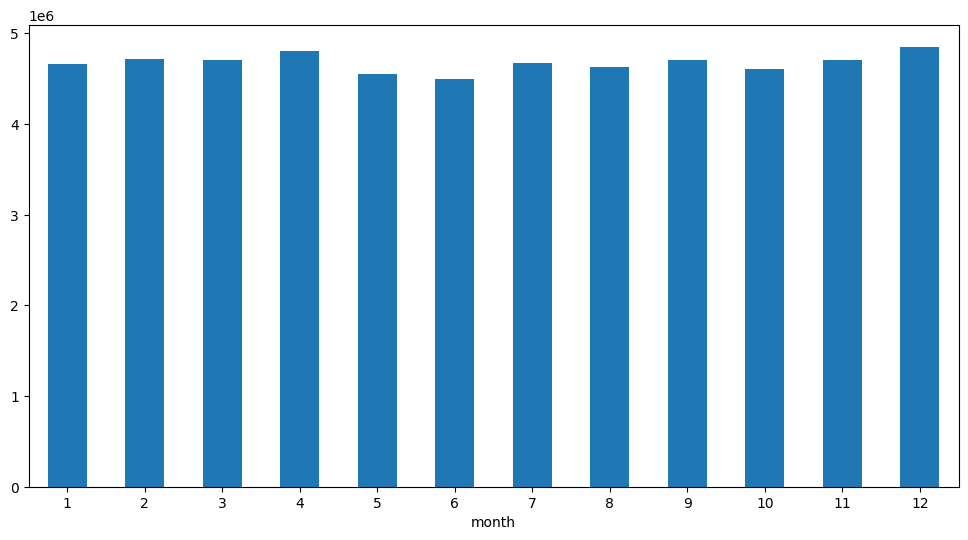

In [155]:
data.groupby(by='month')['last_price'].median().plot(kind='bar', figsize=(12, 6), rot=0);

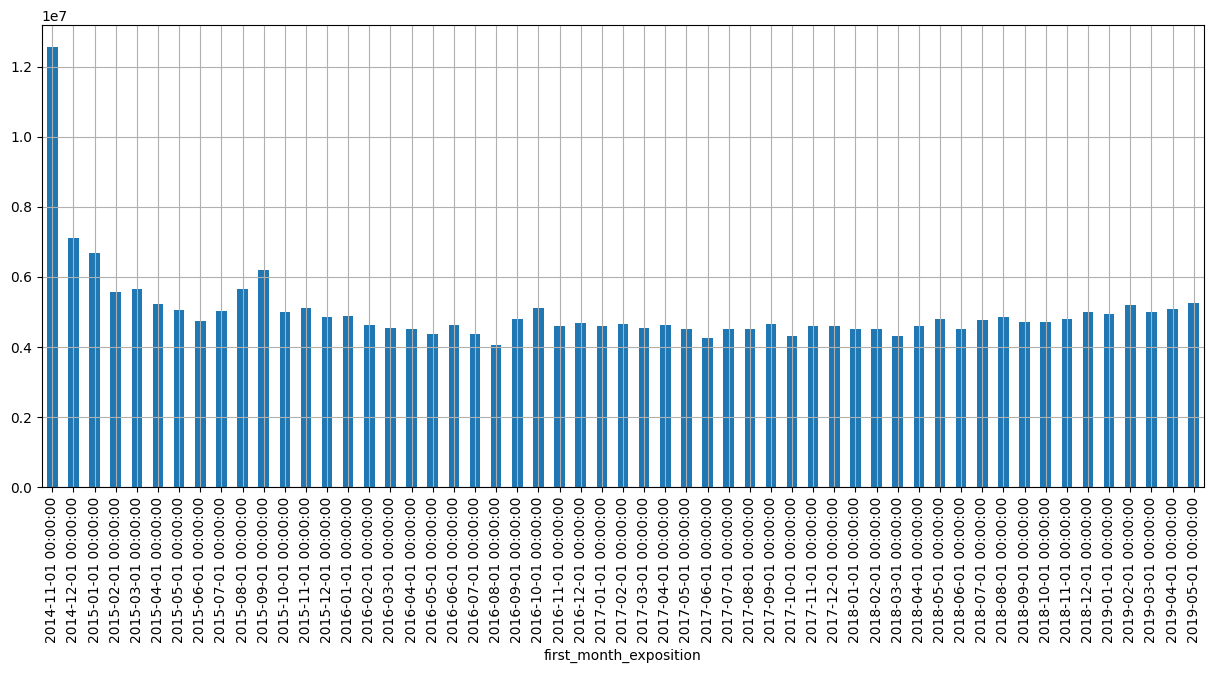

In [156]:
data.groupby(by='first_month_exposition')['last_price'].median().plot(kind='bar', figsize=(15, 6), grid=True);

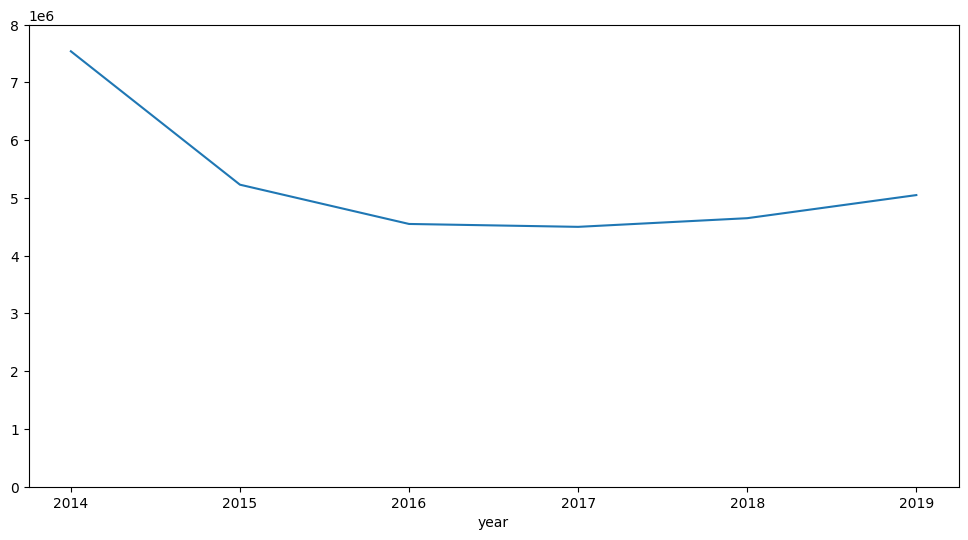

In [157]:
data.groupby(by='year')['last_price'].median().plot(figsize=(12, 6), ylim=(0,8000000));

По графикам видно, что медианная цена объявлений не зависит от дня недели или месяца его размещения. Также можно увидеть, что самые дорогие объявления публиковались в ноябре 2014 года, затем произошел резкий спад цены. Снижение цен продолжалось более плавно в 2015 и 2016 годах, после чего начался плавный рост.

#### Анализ цен за квадратный метр

Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделим населённые пункты с самой высокой и низкой стоимостью квадратного метра.

In [158]:
top_locality = data['locality_name'].value_counts().head(10)

In [159]:
print('Средняя цена квадратного метра в 10 населенных пунктах с наибольшим числом объявлений:')

(
data
    .query('locality_name in @top_locality.index')
    .groupby(by='locality_name')['meter_price']
    .median()
    .round()
    .astype('int')
    .sort_values(ascending=False)
)

Средняя цена квадратного метра в 10 населенных пунктах с наибольшим числом объявлений:


locality_name
Санкт-Петербург    104151
Пушкин             100000
Кудрово             95588
Парголово           92262
Мурино              84692
Шушары              77048
Колпино             74722
Гатчина             67927
Всеволожск          65789
Выборг              58417
Name: meter_price, dtype: int32

In [160]:
print('Среднее значение средних цен:')

(
    data
        .query('locality_name in @top_locality.index')
        .groupby(by='locality_name')['meter_price']
        .median().median().round().astype('int')
)

Среднее значение средних цен:


80870

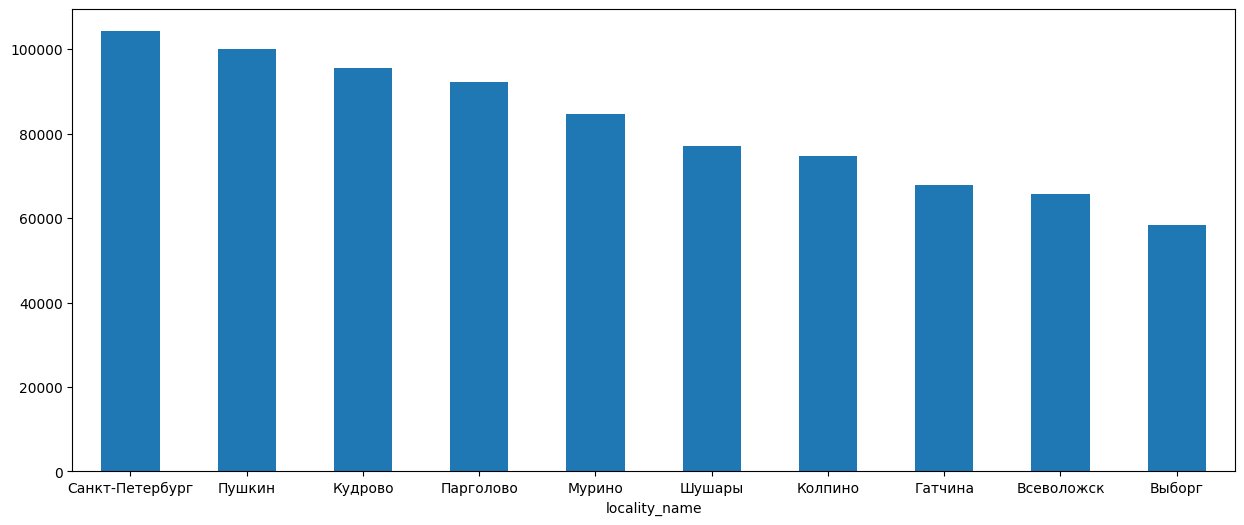

In [161]:
(
data
    .query('locality_name in @top_locality.index')
    .groupby(by='locality_name')['meter_price']
    .median()
    .round(2)
    .sort_values(ascending=False)
    .plot(kind='bar', figsize=(15, 6), rot=0)
);

Средняя цена квадратного метра в 10 городах с наибольшим числом объявлений составляет 80 870 рублей.

Самая высокая средняя цена за квадратный метр - в Санкт-Петербурге (104 151 рубль), самая низкая - в Выборге (58 417 рублей).

#### Связь цен с удаленностью от центра города

Определим, как стоимость объектов зависит от расстояния до центра города.

Ранее мы посчитали расстояние до центра в километрах. Теперь выделим квартиры в Санкт-Петербурге и вычислим среднюю цену каждого километра.

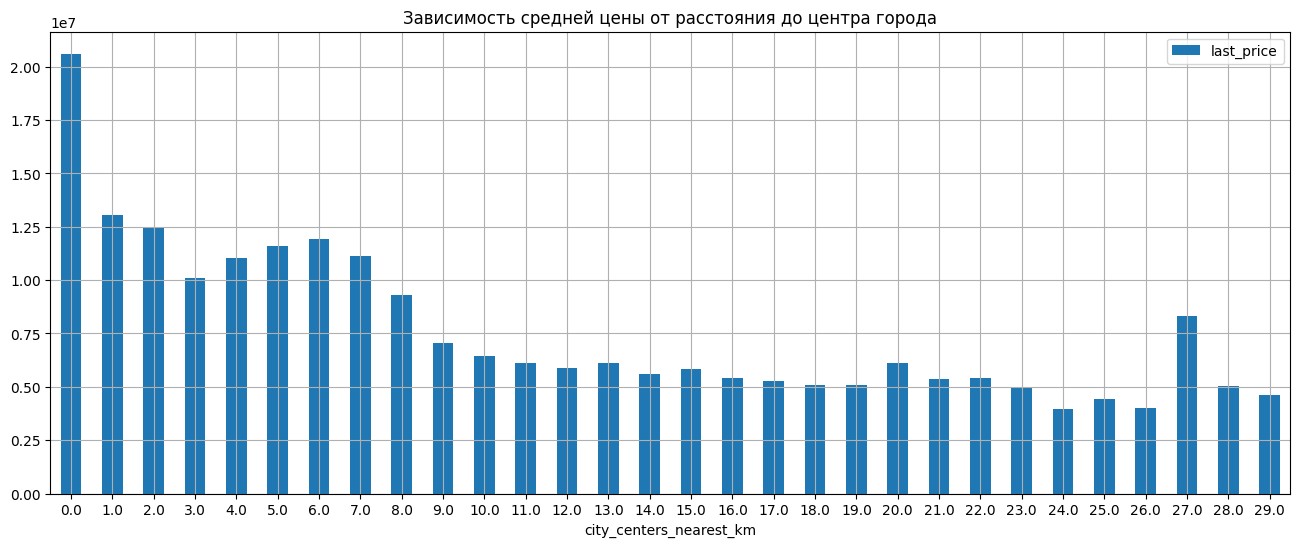

In [162]:
(
data[data['locality_name'] == 'Санкт-Петербург']
    .pivot_table(index='city_centers_nearest_km', 
                 values='last_price', 
                 aggfunc='mean')
    .plot(kind='bar', figsize=(16,6), rot=0, grid=True, 
          title = 'Зависимость средней цены от расстояния до центра города')
)
plt.show();

Как видно из графика, средняя цена сильно зависит от расстояния до центра города. С увеличением расстояния цена снижается. Самые дорогие квартиры находятся в радиусе одного километра от центра. Они оказались почти в два раза дороже квартир на расстоянии двух - трех километров и почти в 3 раза - квартир на расстоянии девяти километров.

После десяти километров от центра средняя цена меняется не так сильно.

Интересно, что квартиры на расстоянии от трех до четырех километров стоят дешевле квартир на расстоянии от пяти до семи. Также видны всплески стоимости на расстояних 20 и 27 километров. Квартиры на расстоянии 27 километров оказались в среднем дороже квартир на расстоянии от 9 до 26 км.

### Общий вывод

В ходе работы был изучен архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за период с ноября 2014 по май 2019. Проделанная работа и полученные результаты:

1. В исходных данных были выявлены и устранены ошибки: заполнены пропущенные значения (высоты потолков, количество балконов и т.д.), устранены аномалии и выбросы (заменены ошибочные значения и удалены выбивающиеся), обработаны дубликаты в названиях населенных пунктов. Были выявлены проблемные места, о которых следует сообщить разработчикам, в частности, об отсутствующей информации на основе геоданных.

2. После этого были добавлены расчетные данные, такие как, например, стоимость квадратного метра продаваемого объекта, день недели, месяц и год публикации объявления.

3. Затем был проведен исследовательский анализ параметров квартир, изучены данные о ценах, площадях, количестве комнат, этажах. Медиана значений общих площадей продаваемых квартир равна 52,2 кв.м., среднее значение - 59,4. Обнаружено много квартир общей площадью около 30, 45, 60 и 80 кв.м, что, скорее всего, обусловлено большим количеством проектов типовой застройки со стандартными площадями жилья.

3. Медиана цен продаваемых квартир равна 4,7 млн. При этом выявлено небольшое число очень дорогих квартир с ценой более 20 млн.

4. Установлено, что "однушек" и "двушек" в выборке больше всего. Немного меньше - "трешек". Квартиры с количеством комнат больше четырех занимают незначительную долю в объявлениях.

5. Больше всего квартир продается на нижних этажах, так как квартиры на низких этажах продают и в малоэтажной застройке, и в высотной. Заметны резкие уменьшения числа продаваемых квартир после 5 и 9 этажей. Это связано с распросраненностью домов соответствующей этажности. Большинство квартир расположены на средних этажах. Квартир на первом и последнем этажах примерно равное количество.

6. Половина продаваемых квартир расположены на расстоянии от 10000 до 16000 метров от центра города. При этом имеются явные всплески в районе 5000, 15000, 22000, 31000 и 53000, что можно объяснить сгруппированностью жилых массивов на указанных расстояних от центра.

7. Больше всего объявлений публикуют по вторникам и четвергам, чуть меньше - по средам и пятницам. В выходные активность минималная.

8. По месяцам минимальная активность публикации новых объявлений - в мае, что, скорее всего, связано с длинными майскими праздниками и началом сезона отпусков. Затем в июне идет всплеск актиности и с июля по ноябрь активность постепенно увиличивается дальше. Затем идет спад активности в декабре и январе. Наибольшая активность наблюдается с февраля по апрель.

9. Среднее время размещения объявления - 185 дней. При этом половина всех сделок закрывается за 101 день или быстрее. Четверть всех продаж происходит в срок до 45 дней. Больше всего сделок закрывают в первые две недели после размещения объявления.

10. Чаще всего объявления снимают с публикации на 45й день. Также видна активность на 30й, 60й и 90й дни, что, скорее всего, связано с особенностью работы платформы или реэлторских агенств, размещающих на ней свои объявления.

11. Необычайно долгими можно считать продажи продолжительностью более 500 дней, так как примерно по этому числу проходит верхняя граница статистически значимой выбрки.

12. После анализа отдельных параметров были проанализированы зависимости цен от них. Была выявлена сильная корреляция цены с общей площадью жилья. Однако, было замечено, что квартиры с одной и той же площадью выставляются в очень широком диапазоне цен. Причем с увеличение площади увеличивается и разброс цен. Также было установлено, что цена зависит от количества комнат, жилой площади и площади кухни в меньшей степени, чем от общей площади квартир.

13. Самые дешевые квартиры - на первом этаже, а средние этажи ценятся больше крайних. При этом в Санкт-Петербурге нет большой разницы между медианными ценами квартир на последних и средних этажей, а в ЛО отсутствует большая разница в ценах между первыми и средними этажами.

14. Цена в объявлениях не зависит от дня недели или месяца размещения. Самые дорогие объявления публиковались в ноябре 2014 года, затем произошел резкий спад цены. Снижение цен продолжалось более плавно в 2015 и 2016 годах, после чего начался плавный рост. 

15. На последнем этапе работы были получены средние цены за квадратный метр. Средняя цена квадратного метра в 10 городах с наибольшим числом объявлений составляет 80 870 рублей. Самая высокая средняя цена за квадратный метр - в Санкт-Петербурге (104 151 рубль), самая низкая - в Выборге (58 417 рублей).

16. Также была изучена зависимость цены от расстояния до центра города. С увеличением расстояния цена снижается. Самые дорогие квартиры находятся в радиусе одного километра от центра. Они оказались почти в два раза дороже квартир на расстоянии двух - трех километров и почти в 3 раза - квартир на расстоянии девяти километров. После десяти километров от центра средняя цена меняется не так сильно. Выявлены относительно дорогие предолжения на расстояних 20 и 27 километров.